In [36]:
import yfinance as yf
import pandas as pd

# 獲取中興電（1513）的歷史數據
ticker = '2881.TW'
data = yf.download(ticker, start='2000-01-01', end='2024-07-15')

# 檢查數據是否成功下載
if not data.empty:
    # 顯示數據
    print(data.head())

    # 將數據保存為 CSV 文件
    data.to_csv('2881_stock_data.csv')
    print("數據已保存為 2881_stock_data.csv")
else:
    print("下載數據失敗，請檢查股票代碼和日期範圍。")


[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2001-12-20  25.115356  25.189444  23.781797  24.152231  10.039165  47460513
2001-12-21  23.337278  24.522663  22.966845  23.189104   9.638829  34280032
2001-12-24  23.337278  23.559538  22.225979  22.225979   9.238497  16577370
2001-12-25  22.374151  23.411366  22.374151  23.263191   9.669625  28114989
2001-12-26  23.263191  23.411366  22.300066  22.522326   9.361675  20843283
數據已保存為 2881_stock_data.csv


# LSTM

/opt/anaconda3/envs/stock_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4828/4828 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - loss: 7.7663e-05
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


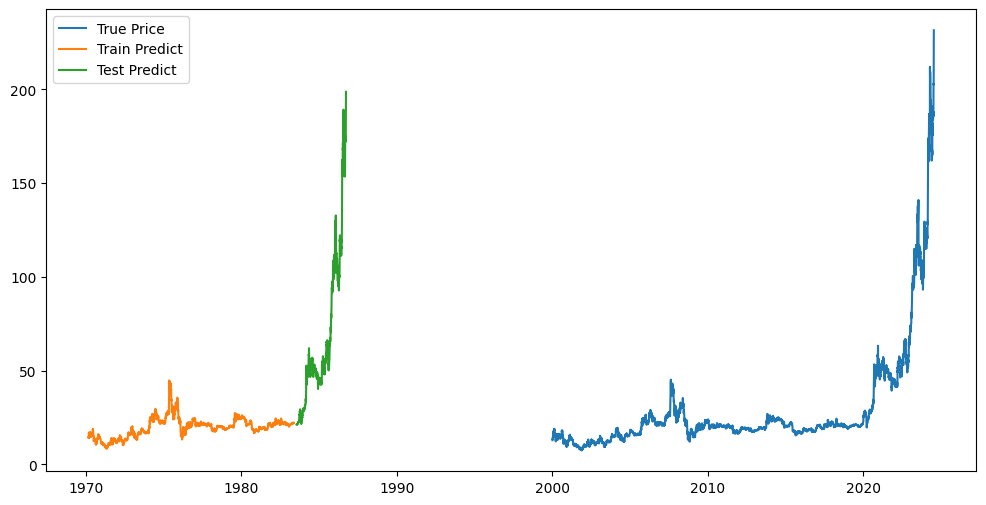

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 讀取數據
df = pd.read_csv('1513_stock_data.csv', index_col='Date', parse_dates=True)
data = df['Close'].values.reshape(-1, 1)

# 正規化數據
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 構建訓練數據集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 重塑數據以符合 LSTM 的輸入要求 [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 構建 LSTM 模型
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
model.fit(X_train, y_train, batch_size=1, epochs=1)

# 預測
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反向正規化數據
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# 可視化結果
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='True Price')
train_plot = np.empty_like(df['Close'])
train_plot[:] = np.nan
train_plot[time_step:len(train_predict)+time_step] = train_predict.flatten()
plt.plot(train_plot, label='Train Predict')

test_plot = np.empty_like(df['Close'])
test_plot[:] = np.nan
test_plot[len(train_predict)+(time_step*2)+1:len(df)-1] = test_predict.flatten()
plt.plot(test_plot, label='Test Predict')

plt.legend()
plt.show()


In [8]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


# 調整模型參數：增加 LSTM 層數、調整 batch_size 和 epochs 數。
# 增加特徵工程：加入技術指標，如移動平均線（MA）、相對強弱指數（RSI）。
# 更長的預測期：預測更多天數的未來價格。
# 評估模型性能：計算 RMSE、MAE 等評估指標

X_train shape: (4829, 60, 4), y_train shape: (4829,)
X_test shape: (1163, 60, 4), y_test shape: (1163,)
Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 4.4199e-04
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 4.5647e-05
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 2.3020e-05
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 2.3383e-05
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 2.1814e-05
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 2.0528e-05
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.9692e-05
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 1.7521e-05
Epoch 9/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 2.2756e-05
Epoch 10/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 1.6303e-05
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Train RMSE: 0.8259550907027173
Test RMSE: 11.193285402800086
Train MAE: 0.5648483418679044
Test

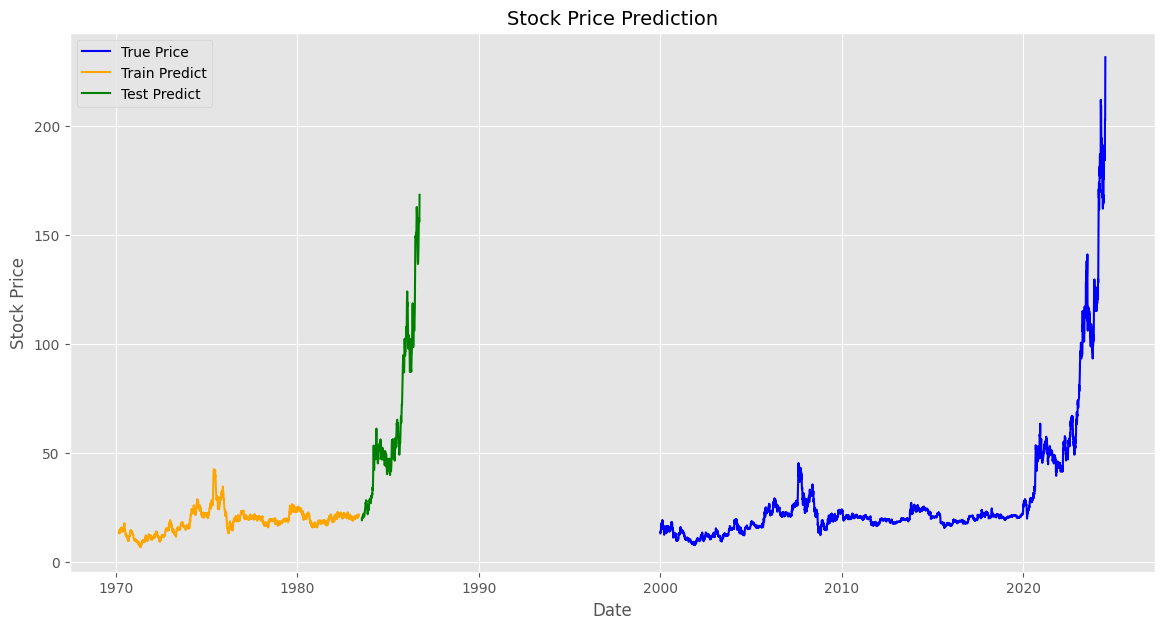

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import tensorflow as tf

# 設置 Matplotlib 風格
plt.style.use('ggplot')

# 檢查 GPU 是否可用
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU is available and configured")
    except RuntimeError as e:
        print(e)

# 讀取數據
df = pd.read_csv('1513_stock_data.csv', index_col='Date', parse_dates=True)
df = df[['Close']]  # 只取收盤價
data = df['Close'].values.reshape(-1, 1)

# 增加特徵工程
# 移動平均線 (MA)
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()

# 相對強弱指數 (RSI)
def compute_RSI(data, window=14):
    diff = data.diff(1).dropna()
    gain = (diff.where(diff > 0, 0)).rolling(window=window).mean()
    loss = (-diff.where(diff < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

df['RSI'] = compute_RSI(df['Close'])
df.fillna(0, inplace=True)

# 正規化數據
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# 構建訓練和測試數據集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), :])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 確認數據集形狀
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

# 重塑數據以符合 LSTM 的輸入要求 [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# 構建 LSTM 模型
model = Sequential()
model.add(Input(shape=(time_step, X_train.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
model.fit(X_train, y_train, batch_size=32, epochs=10)

# 預測
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反向正規化數據
train_predict = scaler.inverse_transform(np.concatenate([train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate([test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]

# 計算評估指標
train_rmse = np.sqrt(mean_squared_error(df['Close'][time_step:train_size], train_predict))
test_rmse = np.sqrt(mean_squared_error(df['Close'][train_size + time_step:], test_predict))
train_mae = mean_absolute_error(df['Close'][time_step:train_size], train_predict)
test_mae = mean_absolute_error(df['Close'][train_size + time_step:], test_predict)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# 可視化結果
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='True Price', color='blue', linewidth=1.5)
train_plot = np.empty_like(df['Close'])
train_plot[:] = np.nan
train_plot[time_step:len(train_predict)+time_step] = train_predict
plt.plot(train_plot, label='Train Predict', color='orange', linewidth=1.5)

test_plot = np.empty_like(df['Close'])
test_plot[:] = np.nan
test_plot[len(train_predict)+(time_step*2):len(train_predict)+(time_step*2)+len(test_predict)] = test_predict
plt.plot(test_plot, label='Test Predict', color='green', linewidth=1.5)

plt.title('Stock Price Prediction', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


# 增加數據特徵：可以考慮增加更多的技術指標和特徵。
# 調整模型結構：增加或減少 LSTM 層數，改變神經元數量。
# 正則化：添加 Dropout 層來減少過擬合。
# 調整超參數：改變 batch size 和學習率，增加訓練輪數。


X_train shape: (4829, 60, 4), y_train shape: (4829,)
X_test shape: (1163, 60, 4), y_test shape: (1163,)
Epoch 1/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 5.4215e-04
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 6.5701e-05
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 4.4607e-05
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 4.6941e-05
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 4.5315e-05
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 3.9520e-05
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 3.7220e-05
Epoch 8/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 3.3031e-05
Epoch 9/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 3.0157e-05
Epoch 10/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 2.9693e-05
Epoch 11/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 3.0227e-05
Epoch 12/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 2.8784e-05
Epoch 13/20
151/151 ━━━━━━━━━

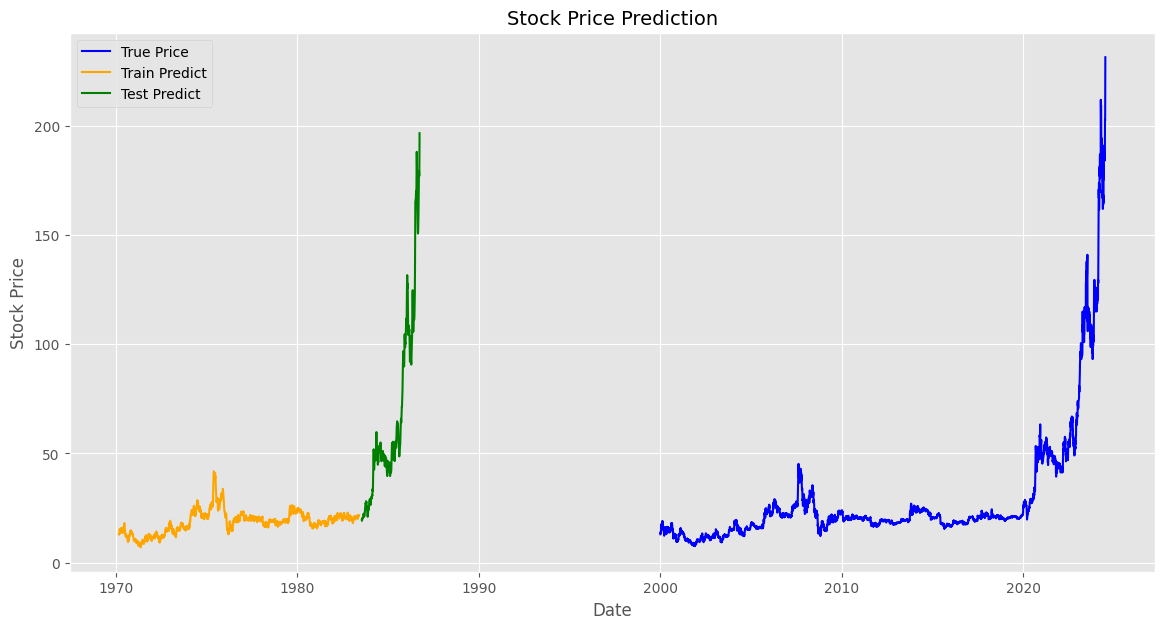

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import tensorflow as tf

# 設置 Matplotlib 風格
plt.style.use('ggplot')

# 檢查 GPU 是否可用
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU is available and configured")
    except RuntimeError as e:
        print(e)

# 讀取數據
df = pd.read_csv('1513_stock_data.csv', index_col='Date', parse_dates=True)
df = df[['Close']]  # 只取收盤價
data = df['Close'].values.reshape(-1, 1)

# 增加特徵工程
# 移動平均線 (MA)
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()

# 相對強弱指數 (RSI)
def compute_RSI(data, window=14):
    diff = data.diff(1).dropna()
    gain = (diff.where(diff > 0, 0)).rolling(window=window).mean()
    loss = (-diff.where(diff < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

df['RSI'] = compute_RSI(df['Close'])
df.fillna(0, inplace=True)

# 正規化數據
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# 構建訓練和測試數據集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), :])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 確認數據集形狀
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

# 重塑數據以符合 LSTM 的輸入要求 [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# 構建 LSTM 模型
model = Sequential()
model.add(Input(shape=(time_step, X_train.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
model.fit(X_train, y_train, batch_size=32, epochs=20)

# 預測
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反向正規化數據
train_predict = scaler.inverse_transform(np.concatenate([train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate([test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]

# 計算評估指標
train_rmse = np.sqrt(mean_squared_error(df['Close'][time_step:train_size], train_predict))
test_rmse = np.sqrt(mean_squared_error(df['Close'][train_size + time_step:], test_predict))
train_mae = mean_absolute_error(df['Close'][time_step:train_size], train_predict)
test_mae = mean_absolute_error(df['Close'][train_size + time_step:], test_predict)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# 可視化結果
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='True Price', color='blue', linewidth=1.5)
train_plot = np.empty_like(df['Close'])
train_plot[:] = np.nan
train_plot[time_step:len(train_predict)+time_step] = train_predict
plt.plot(train_plot, label='Train Predict', color='orange', linewidth=1.5)

test_plot = np.empty_like(df['Close'])
test_plot[:] = np.nan
test_plot[len(train_predict)+(time_step*2):len(train_predict)+(time_step*2)+len(test_predict)] = test_predict
plt.plot(test_plot, label='Test Predict', color='green', linewidth=1.5)

plt.title('Stock Price Prediction', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


# 增加技術指標：添加布林帶和 MACD 作為額外特徵。
# 調整 Dropout 比率：增加 Dropout 比率以減少過擬合。
# 調整模型架構：使用不同的 LSTM 層數和單元數。


X_train shape: (4829, 60, 8), y_train shape: (4829,)
X_test shape: (1163, 60, 8), y_test shape: (1163,)
Epoch 1/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0015
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.0039e-04
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 6.8962e-05
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 6.2103e-05
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 5.2266e-05
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 5.1736e-05
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 3.8614e-05
Epoch 8/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 4.0769e-05
Epoch 9/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 3.8288e-05
Epoch 10/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 4.0040e-05
Epoch 11/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 3.6306e-05
Epoch 12/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 3.1195e-05
Epoch 13/20
151/151 ━━━━━━━━━━━━━

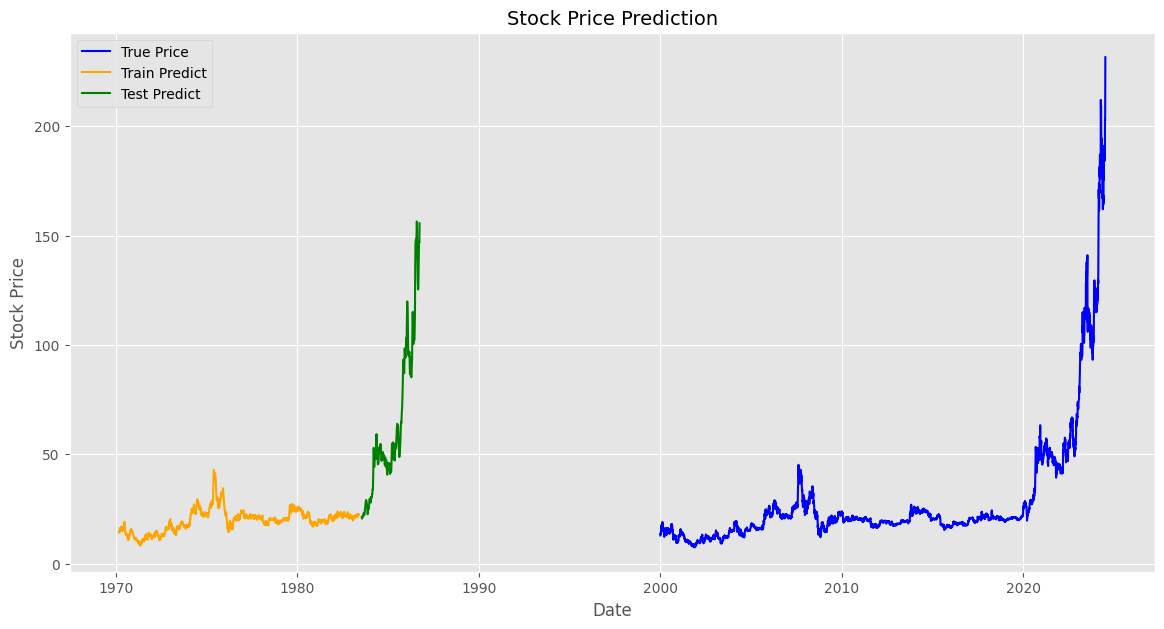

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import tensorflow as tf

# 設置 Matplotlib 風格
plt.style.use('ggplot')

# 檢查 GPU 是否可用
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU is available and configured")
    except RuntimeError as e:
        print(e)

# 讀取數據
df = pd.read_csv('1513_stock_data.csv', index_col='Date', parse_dates=True)
df = df[['Close']]  # 只取收盤價

# 增加特徵工程
# 移動平均線 (MA)
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()

# 相對強弱指數 (RSI)
def compute_RSI(data, window=14):
    diff = data.diff(1).dropna()
    gain = (diff.where(diff > 0, 0)).rolling(window=window).mean()
    loss = (-diff.where(diff < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

df['RSI'] = compute_RSI(df['Close'])

# 布林帶（Bollinger Bands）
df['Bollinger_Upper'] = df['Close'].rolling(window=20).mean() + 2*df['Close'].rolling(window=20).std()
df['Bollinger_Lower'] = df['Close'].rolling(window=20).mean() - 2*df['Close'].rolling(window=20).std()

# 移動平均收斂散度指標（MACD）
df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

df.fillna(0, inplace=True)

# 正規化數據
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# 構建訓練和測試數據集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), :])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 確認數據集形狀
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

# 重塑數據以符合 LSTM 的輸入要求 [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# 構建 LSTM 模型
model = Sequential()
model.add(Input(shape=(time_step, X_train.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(25))
model.add(Dense(1))

# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
model.fit(X_train, y_train, batch_size=32, epochs=20)

# 預測
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反向正規化數據
train_predict = scaler.inverse_transform(np.concatenate([train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate([test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]

# 計算評估指標
train_rmse = np.sqrt(mean_squared_error(df['Close'][time_step:train_size], train_predict))
test_rmse = np.sqrt(mean_squared_error(df['Close'][train_size + time_step:], test_predict))
train_mae = mean_absolute_error(df['Close'][time_step:train_size], train_predict)
test_mae = mean_absolute_error(df['Close'][train_size + time_step:], test_predict)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# 可視化結果
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='True Price', color='blue', linewidth=1.5)
train_plot = np.empty_like(df['Close'])
train_plot[:] = np.nan
train_plot[time_step:len(train_predict)+time_step] = train_predict
plt.plot(train_plot, label='Train Predict', color='orange', linewidth=1.5)

test_plot = np.empty_like(df['Close'])
test_plot[:] = np.nan
test_plot[len(train_predict)+(time_step*2):len(train_predict)+(time_step*2)+len(test_predict)] = test_predict
plt.plot(test_plot, label='Test Predict', color='green', linewidth=1.5)

plt.title('Stock Price Prediction', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


# 增加數據增強：在數據準備過程中，使用不同的時間窗口大小進行數據增強。
# 調整模型架構：增加或減少 LSTM 層的數量和單元數，嘗試雙向 LSTM。
# 超參數調整：進一步調整學習率、batch size 等超參數。
# 早停法：在訓練過程中使用 EarlyStopping 來防止過擬合。


X_train shape: (4829, 60, 8), y_train shape: (4829,)
X_test shape: (1163, 60, 8), y_test shape: (1163,)
Epoch 1/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 0.0029 - val_loss: 1.7012e-05
Epoch 2/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 1.5019e-04 - val_loss: 2.7901e-05
Epoch 3/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 1.0886e-04 - val_loss: 2.0143e-05
Epoch 4/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 7.6687e-05 - val_loss: 1.0234e-05
Epoch 5/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 6.6900e-05 - val_loss: 2.4321e-05
Epoch 6/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 5.6280e-05 - val_loss: 7.6080e-06
Epoch 7/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 5.1495e-05 - val_loss: 9.5509e-06
Epoch 8/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 4.5261e-05 - val_loss: 1.6837e-05
Epoch 9/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 4.4783e-05 - val_loss: 1.0908e-05
Epoch 10/100
121/121 ━━━━━━━━━━━━━━━

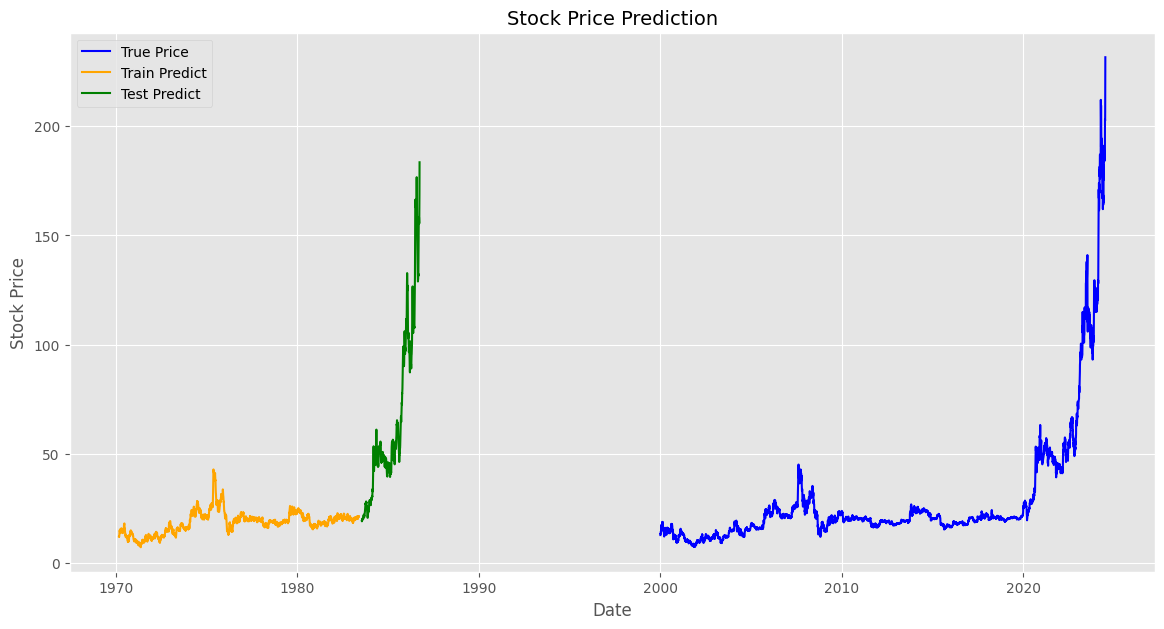

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# 設置 Matplotlib 風格
plt.style.use('ggplot')

# 檢查 GPU 是否可用
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU is available and configured")
    except RuntimeError as e:
        print(e)

# 讀取數據
df = pd.read_csv('1513_stock_data.csv', index_col='Date', parse_dates=True)
df = df[['Close']]  # 只取收盤價

# 增加特徵工程
# 移動平均線 (MA)
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()

# 相對強弱指數 (RSI)
def compute_RSI(data, window=14):
    diff = data.diff(1).dropna()
    gain = (diff.where(diff > 0, 0)).rolling(window=window).mean()
    loss = (-diff.where(diff < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

df['RSI'] = compute_RSI(df['Close'])

# 布林帶（Bollinger Bands）
df['Bollinger_Upper'] = df['Close'].rolling(window=20).mean() + 2*df['Close'].rolling(window=20).std()
df['Bollinger_Lower'] = df['Close'].rolling(window=20).mean() - 2*df['Close'].rolling(window=20).std()

# 移動平均收斂散度指標（MACD）
df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

df.fillna(0, inplace=True)

# 正規化數據
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# 構建訓練和測試數據集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), :])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 確認數據集形狀
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

# 重塑數據以符合 LSTM 的輸入要求 [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# 構建 LSTM 模型
model = Sequential()
model.add(Input(shape=(time_step, X_train.shape[2])))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(50, return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(25))
model.add(Dense(1))

# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 設置早停法
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 訓練模型
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stop])

# 預測
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反向正規化數據
train_predict = scaler.inverse_transform(np.concatenate([train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate([test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]

# 計算評估指標
train_rmse = np.sqrt(mean_squared_error(df['Close'][time_step:train_size], train_predict))
test_rmse = np.sqrt(mean_squared_error(df['Close'][train_size + time_step:], test_predict))
train_mae = mean_absolute_error(df['Close'][time_step:train_size], train_predict)
test_mae = mean_absolute_error(df['Close'][train_size + time_step:], test_predict)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# 可視化結果
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='True Price', color='blue', linewidth=1.5)
train_plot = np.empty_like(df['Close'])
train_plot[:] = np.nan
train_plot[time_step:len(train_predict)+time_step] = train_predict
plt.plot(train_plot, label='Train Predict', color='orange', linewidth=1.5)

test_plot = np.empty_like(df['Close'])
test_plot[:] = np.nan
test_plot[len(train_predict)+(time_step*2):len(train_predict)+(time_step*2)+len(test_predict)] = test_predict
plt.plot(test_plot, label='Test Predict', color='green', linewidth=1.5)

plt.title('Stock Price Prediction', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [1]:
import tensorflow as tf

# 檢查是否有可用的 GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"GPUs available: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found")


GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 針對接下來五天進行預測

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
X_train shape: (4829, 60, 8), y_train shape: (4829,)
X_test shape: (1163, 60, 8), y_test shape: (1163,)


2024-07-15 10:53:33.892836: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-07-15 10:53:33.892859: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-15 10:53:33.892874: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-15 10:53:33.892908: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-15 10:53:33.892920: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2024-07-15 10:53:35.180381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


121/121 ━━━━━━━━━━━━━━━━━━━━ 31s 208ms/step - loss: 0.0022 - val_loss: 3.3828e-05
Epoch 2/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 23s 190ms/step - loss: 1.5028e-04 - val_loss: 8.3144e-06
Epoch 3/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 23s 192ms/step - loss: 9.9336e-05 - val_loss: 5.8616e-06
Epoch 4/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 22s 184ms/step - loss: 6.7860e-05 - val_loss: 2.1355e-05
Epoch 5/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 23s 188ms/step - loss: 6.1893e-05 - val_loss: 5.2972e-06
Epoch 6/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 22s 182ms/step - loss: 5.9531e-05 - val_loss: 7.0553e-06
Epoch 7/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - loss: 4.6351e-05 - val_loss: 6.7703e-06
Epoch 8/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 22s 182ms/step - loss: 4.5687e-05 - val_loss: 5.2520e-06
Epoch 9/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 22s 185ms/step - loss: 3.9789e-05 - val_loss: 5.5107e-06
Epoch 10/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 23s 193ms/step - loss: 3.7147e-05 - val_loss: 8.9985e-06
Epoch 11/100
121/121 ━━━━━━━━━━━━━━

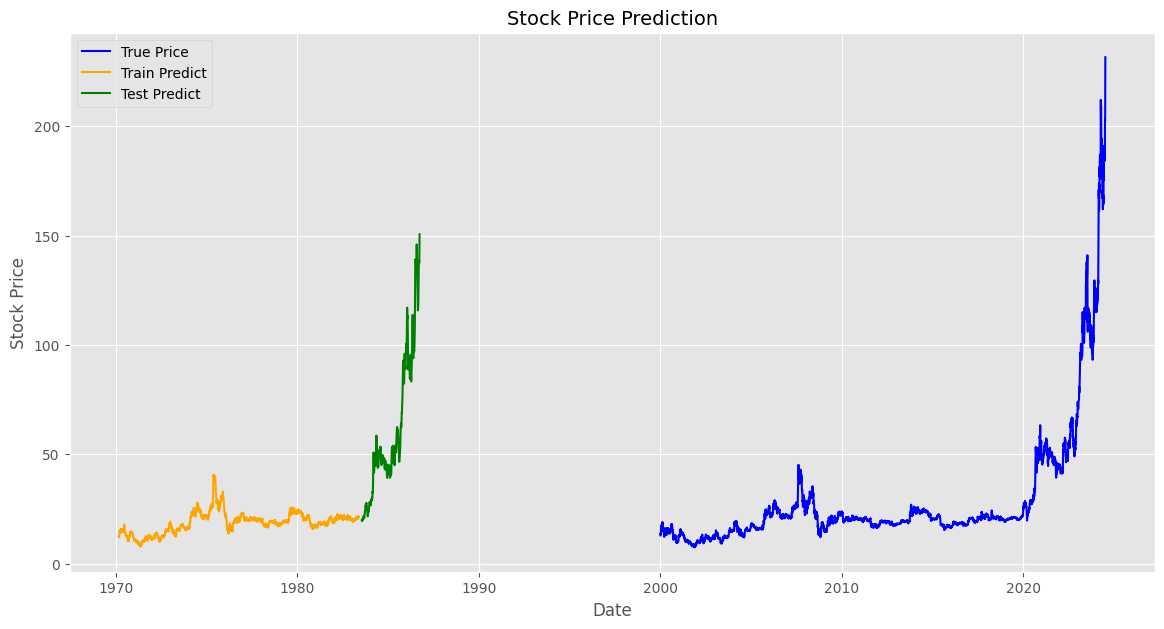

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Next 5 days predictions: [153.34795943 144.9558886  135.56753703 125.67622612 115.67355882]
Probability of increase: 0.0%
Average increase: 135.04423399974792


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# 確認 GPU 是否可用
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"GPUs available: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found")

# 設置 Matplotlib 風格
plt.style.use('ggplot')

# 讀取數據
df = pd.read_csv('1513_stock_data.csv', index_col='Date', parse_dates=True)
df = df[['Close']]  # 只取收盤價

# 增加特徵工程
# 移動平均線 (MA)
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()

# 相對強弱指數 (RSI)
def compute_RSI(data, window=14):
    diff = data.diff(1).dropna()
    gain = (diff.where(diff > 0, 0)).rolling(window=window).mean()
    loss = (-diff.where(diff < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

df['RSI'] = compute_RSI(df['Close'])

# 布林帶（Bollinger Bands）
df['Bollinger_Upper'] = df['Close'].rolling(window=20).mean() + 2*df['Close'].rolling(window=20).std()
df['Bollinger_Lower'] = df['Close'].rolling(window=20).mean() - 2*df['Close'].rolling(window=20).std()

# 移動平均收斂散度指標（MACD）
df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

df.fillna(0, inplace=True)

# 正規化數據
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# 構建訓練和測試數據集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), :])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 確認數據集形狀
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

# 重塑數據以符合 LSTM 的輸入要求 [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# 構建 LSTM 模型
model = Sequential()
model.add(Input(shape=(time_step, X_train.shape[2])))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(50, return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(25))
model.add(Dense(1))

# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 設置早停法
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 訓練模型
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stop])

# 預測
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反向正規化數據
train_predict = scaler.inverse_transform(np.concatenate([train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate([test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]

# 計算評估指標
train_rmse = np.sqrt(mean_squared_error(df['Close'][time_step:train_size], train_predict))
test_rmse = np.sqrt(mean_squared_error(df['Close'][train_size + time_step:], test_predict))
train_mae = mean_absolute_error(df['Close'][time_step:train_size], train_predict)
test_mae = mean_absolute_error(df['Close'][train_size + time_step:], test_predict)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# 可視化結果
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='True Price', color='blue', linewidth=1.5)
train_plot = np.empty_like(df['Close'])
train_plot[:] = np.nan
train_plot[time_step:len(train_predict)+time_step] = train_predict
plt.plot(train_plot, label='Train Predict', color='orange', linewidth=1.5)

test_plot = np.empty_like(df['Close'])
test_plot[:] = np.nan
test_plot[len(train_predict)+(time_step*2):len(train_predict)+(time_step*2)+len(test_predict)] = test_predict
plt.plot(test_plot, label='Test Predict', color='green', linewidth=1.5)

plt.title('Stock Price Prediction', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# 進行未來5天的預測
def predict_next_days(model, data, n_days=5):
    predictions = []
    current_input = data[-time_step:].reshape(1, time_step, data.shape[1])
    
    for _ in range(n_days):
        next_pred = model.predict(current_input)
        predictions.append(next_pred[0, 0])
        
        # 更新輸入數據
        next_input = np.append(current_input[:, 1:, :], np.zeros((1, 1, data.shape[1])), axis=1)
        next_input[0, -1, 0] = next_pred  # 更新預測值到下一步的輸入中
        current_input = next_input

    return predictions

# 預測接下來的5天
next_5_days_scaled = predict_next_days(model, scaled_data, n_days=5)
next_5_days = scaler.inverse_transform(np.concatenate([np.array(next_5_days_scaled).reshape(-1, 1), np.zeros((5, scaled_data.shape[1] - 1))], axis=1))[:, 0]

print(f'Next 5 days predictions: {next_5_days}')

# 計算上漲機率和幅度
def calculate_increase_probability(predictions):
    increases = [1 if predictions[i] > predictions[i-1] else 0 for i in range(1, len(predictions))]
    probability = sum(increases) / len(increases)
    return probability, np.mean(predictions)

probability, mean_increase = calculate_increase_probability(next_5_days)
print(f'Probability of increase: {probability * 100}%')
print(f'Average increase: {mean_increase}')


## 調整批量大小：嘗試增大批量大小，看看是否能提升 GPU 的利用效率。一般建議從 64、128、256 這些數值開始測試。
## 增加模型複雜度：增加模型的深度或者每層神經元的數量，以充分利用 GPU 的計算能力。
## 混合精度訓練：已經使用了混合精度訓練，可以檢查這部分是否正常工作。
## 數據預處理：確保數據預處理步驟在 GPU 上進行

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
X_train shape: (4829, 60, 8), y_train shape: (4829,)
X_test shape: (1163, 60, 8), y_test shape: (1163,)
Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0069 - val_loss: 1.6156e-04
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 4.4387e-04 - val_loss: 3.4842e-05
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 2.3321e-04 - val_loss: 1.2861e-05
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 1.6871e-04 - val_loss: 1.2413e-05
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 1.4589e-04 - val_loss: 1.1249e-05
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 1.2007e-04 - val_loss: 1.5727e-05
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 1.1186e-04 - val_loss: 1.1701e-05
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 9.7888e-05 - val_loss: 9.7966e-06
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 8.3

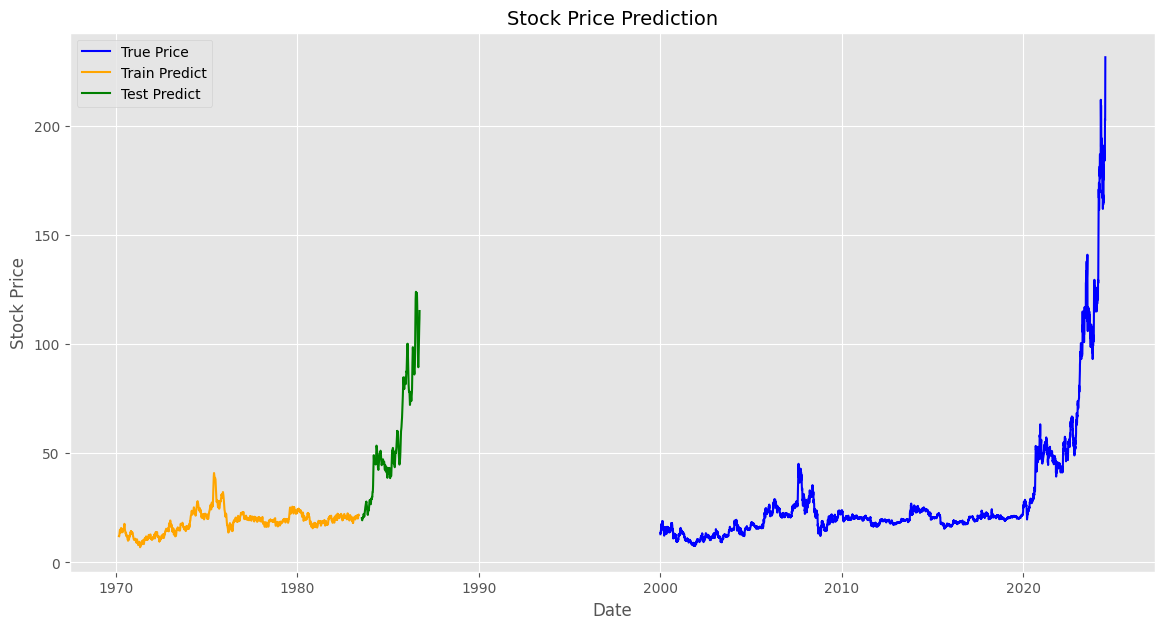

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Next 5 days predictions: [117.44370119 115.31129675 112.24938269 108.53134418 104.32121235]
Probability of increase: 0.0%
Average increase: 111.5713874308858


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# 檢查 GPU 是否可用
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"GPUs available: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found")

# 使用混合精度訓練
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# 設置 Matplotlib 風格
plt.style.use('ggplot')

# 讀取數據
df = pd.read_csv('1513_stock_data.csv', index_col='Date', parse_dates=True)
df = df[['Close']]  # 只取收盤價

# 增加特徵工程
# 移動平均線 (MA)
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()

# 相對強弱指數 (RSI)
def compute_RSI(data, window=14):
    diff = data.diff(1).dropna()
    gain = (diff.where(diff > 0, 0)).rolling(window=window).mean()
    loss = (-diff.where(diff < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

df['RSI'] = compute_RSI(df['Close'])

# 布林帶（Bollinger Bands）
df['Bollinger_Upper'] = df['Close'].rolling(window=20).mean() + 2*df['Close'].rolling(window=20).std()
df['Bollinger_Lower'] = df['Close'].rolling(window=20).mean() - 2*df['Close'].rolling(window=20).std()

# 移動平均收斂散度指標（MACD）
df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

df.fillna(0, inplace=True)

# 正規化數據
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# 構建訓練和測試數據集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), :])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 確認數據集形狀
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

# 重塑數據以符合 LSTM 的輸入要求 [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# 構建 LSTM 模型
model = Sequential()
model.add(Input(shape=(time_step, X_train.shape[2])))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(50, return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(25))
model.add(Dense(1))

# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 設置早停法
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 訓練模型
history = model.fit(X_train, y_train, batch_size=128, epochs=100, validation_split=0.2, callbacks=[early_stop])

# 預測
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反向正規化數據
train_predict = scaler.inverse_transform(np.concatenate([train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate([test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]

# 計算評估指標
train_rmse = np.sqrt(mean_squared_error(df['Close'][time_step:train_size], train_predict))
test_rmse = np.sqrt(mean_squared_error(df['Close'][train_size + time_step:], test_predict))
train_mae = mean_absolute_error(df['Close'][time_step:train_size], train_predict)
test_mae = mean_absolute_error(df['Close'][train_size + time_step:], test_predict)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# 可視化結果
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='True Price', color='blue', linewidth=1.5)
train_plot = np.empty_like(df['Close'])
train_plot[:] = np.nan
train_plot[time_step:len(train_predict)+time_step] = train_predict
plt.plot(train_plot, label='Train Predict', color='orange', linewidth=1.5)

test_plot = np.empty_like(df['Close'])
test_plot[:] = np.nan
test_plot[len(train_predict)+(time_step*2):len(train_predict)+(time_step*2)+len(test_predict)] = test_predict
plt.plot(test_plot, label='Test Predict', color='green', linewidth=1.5)

plt.title('Stock Price Prediction', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# 進行未來5天的預測
def predict_next_days(model, data, n_days=5):
    predictions = []
    current_input = data[-time_step:].reshape(1, time_step, data.shape[1])
    
    for _ in range(n_days):
        next_pred = model.predict(current_input)
        predictions.append(next_pred[0, 0])
        
        # 更新輸入數據
        next_input = np.append(current_input[:, 1:, :], np.zeros((1, 1, data.shape[1])), axis=1)
        next_input[0, -1, 0] = next_pred  # 更新預測值到下一步的輸入中
        current_input = next_input

    return predictions

# 預測接下來的5天
next_5_days_scaled = predict_next_days(model, scaled_data, n_days=5)
next_5_days = scaler.inverse_transform(np.concatenate([np.array(next_5_days_scaled).reshape(-1, 1), np.zeros((5, scaled_data.shape[1] - 1))], axis=1))[:, 0]

print(f'Next 5 days predictions: {next_5_days}')

# 計算上漲機率和幅度
def calculate_increase_probability(predictions):
    increases = [1 if predictions[i] > predictions[i-1] else 0 for i in range(1, len(predictions))]
    probability = sum(increases) / len(increases)
    return probability, np.mean(predictions)

probability, mean_increase = calculate_increase_probability(next_5_days)
print(f'Probability of increase: {probability * 100}%')
print(f'Average increase: {mean_increase}')


GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
X_train shape: (4829, 60, 8), y_train shape: (4829,)
X_test shape: (1163, 60, 8), y_test shape: (1163,)
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - loss: 0.0063 - val_loss: 3.5967e-04
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 8.4891e-04 - val_loss: 4.8863e-05
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 3.3864e-04 - val_loss: 5.3986e-05
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 2.4572e-04 - val_loss: 1.5351e-05
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 2.0775e-04 - val_loss: 1.3208e-05
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 1.6801e-04 - val_loss: 9.8754e-06
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 1.4213e-04 - val_loss: 9.5015e-06
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 1.3806e-04 - val_loss: 9.1408e-06
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - lo

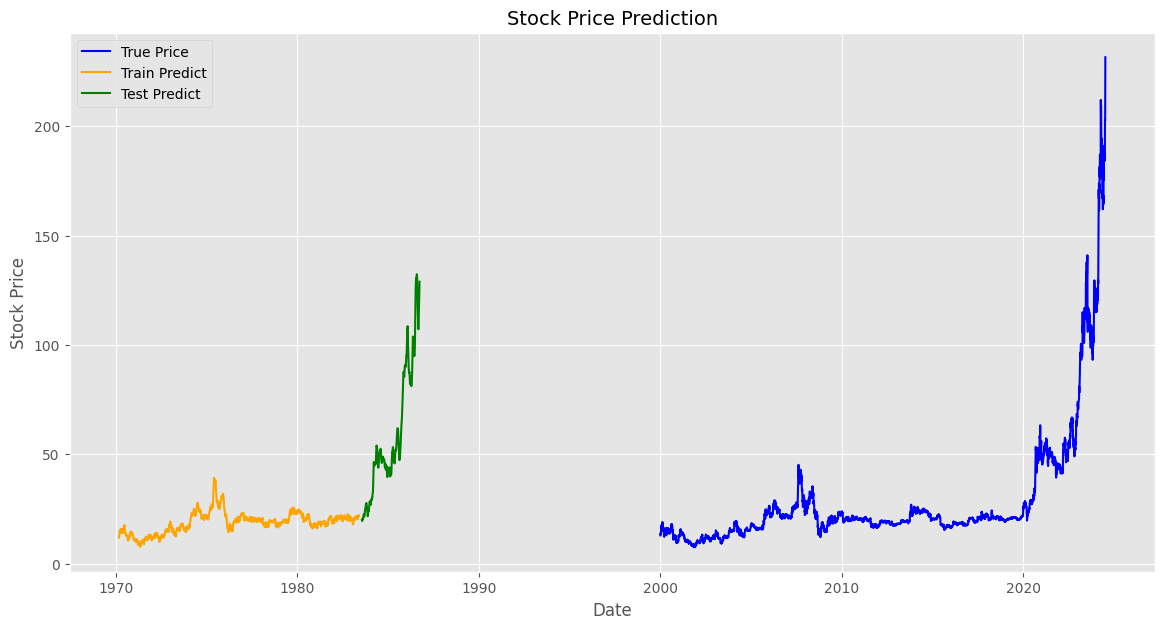

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# 檢查 GPU 是否可用
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"GPUs available: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found")

# 使用混合精度訓練
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# 設置 Matplotlib 風格
plt.style.use('ggplot')

# 讀取數據
df = pd.read_csv('1513_stock_data.csv', index_col='Date', parse_dates=True)
df = df[['Close']]  # 只取收盤價

# 增加特徵工程
# 移動平均線 (MA)
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()

# 相對強弱指數 (RSI)
def compute_RSI(data, window=14):
    diff = data.diff(1).dropna()
    gain = (diff.where(diff > 0, 0)).rolling(window=window).mean()
    loss = (-diff.where(diff < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

df['RSI'] = compute_RSI(df['Close'])

# 布林帶（Bollinger Bands）
df['Bollinger_Upper'] = df['Close'].rolling(window=20).mean() + 2*df['Close'].rolling(window=20).std()
df['Bollinger_Lower'] = df['Close'].rolling(window=20).mean() - 2*df['Close'].rolling(window=20).std()

# 移動平均收斂散度指標（MACD）
df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

df.fillna(0, inplace=True)

# 正規化數據
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# 構建訓練和測試數據集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), :])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 確認數據集形狀
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

# 重塑數據以符合 LSTM 的輸入要求 [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# 構建 LSTM 模型
model = Sequential()
model.add(Input(shape=(time_step, X_train.shape[2])))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(50, return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(25))
model.add(Dense(1))

# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 設置早停法
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 訓練模型
history = model.fit(X_train, y_train, batch_size=256, epochs=100, validation_split=0.2, callbacks=[early_stop])

# 預測
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反向正規化數據
train_predict = scaler.inverse_transform(np.concatenate([train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate([test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]

# 計算評估指標
train_rmse = np.sqrt(mean_squared_error(df['Close'][time_step:train_size], train_predict))
test_rmse = np.sqrt(mean_squared_error(df['Close'][train_size + time_step:], test_predict))
train_mae = mean_absolute_error(df['Close'][time_step:train_size], train_predict)
test_mae = mean_absolute_error(df['Close'][train_size + time_step:], test_predict)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# 可視化結果
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='True Price', color='blue', linewidth=1.5)
train_plot = np.empty_like(df['Close'])
train_plot[:] = np.nan
train_plot[time_step:len(train_predict)+time_step] = train_predict
plt.plot(train_plot, label='Train Predict', color='orange', linewidth=1.5)

test_plot = np.empty_like(df['Close'])
test_plot[:] = np.nan
test_plot[len(train_predict)+(time_step*2):len(train_predict)+(time_step*2)+len(test_predict)] = test_predict
plt.plot(test_plot, label='Test Predict', color='green', linewidth=1.5)

plt.title('Stock Price Prediction', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [19]:
print(df.tail())

            Close    MA10     MA20        RSI  Bollinger_Upper  \
Date                                                             
2024-07-08  202.5  191.45  187.950  71.641791       202.342615   
2024-07-09  207.5  193.35  189.450  75.324675       205.423333   
2024-07-10  228.0  197.50  192.075  83.898305       214.391562   
2024-07-11  228.0  201.70  194.450  83.898305       221.241397   
2024-07-12  231.5  206.05  196.475  90.598291       227.891514   

            Bollinger_Lower       MACD  Signal_Line  
Date                                                 
2024-07-08       173.557385   5.837971     4.277671  
2024-07-09       173.476667   6.636072     4.749352  
2024-07-10       169.758438   8.821068     5.563695  
2024-07-11       167.658603  10.432435     6.537443  
2024-07-12       165.058486  11.855216     7.600997  


In [18]:
# 進行未來5天的預測
def predict_next_days(model, data, n_days=5):
    predictions = []
    current_input = data[-time_step:].reshape(1, time_step, data.shape[1])
    
    for _ in range(n_days):
        next_pred = model.predict(current_input)
        predictions.append(next_pred[0, 0])
        
        # 更新輸入數據
        next_pred_reshaped = np.full((1, 1, data.shape[1]), next_pred[0, 0])
        next_input = np.append(current_input[:, 1:, :], next_pred_reshaped, axis=1)
        current_input = next_input

    return predictions

# 獲取未來5天的日期
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=6)[1:]

next_5_days_scaled = predict_next_days(model, scaled_data, n_days=5)
next_5_days = scaler.inverse_transform(np.concatenate([np.array(next_5_days_scaled).reshape(-1, 1), np.zeros((5, scaled_data.shape[1] - 1))], axis=1))[:, 0]

# 將預測結果與日期一起顯示
future_predictions = pd.Series(next_5_days, index=future_dates)
print(f'Next 5 days predictions:\n{future_predictions}')

# 計算上漲機率和幅度
def calculate_increase_probability(predictions):
    increases = [1 if predictions[i] > predictions[i-1] else 0 for i in range(1, len(predictions))]
    probability = sum(increases) / len(increases)
    return probability, np.mean(predictions)

probability, mean_increase = calculate_increase_probability(next_5_days)
print(f'Probability of increase: {probability * 100}%')
print(f'Average increase: {mean_increase}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Next 5 days predictions:
2024-07-13    130.675544
2024-07-14    130.238128
2024-07-15    129.253941
2024-07-16    127.832338
2024-07-17    126.192027
Freq: D, dtype: float64
Probability of increase: 0.0%
Average increase: 128.8383956598118


# 新增了MA10、MA20、RSI、Bollinger Bands、MACD和Signal Line作為特徵

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# 檢查 GPU 是否可用
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"GPUs available: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found")

# 使用混合精度訓練
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# 設置 Matplotlib 風格
plt.style.use('ggplot')

# 讀取數據
df = pd.read_csv('1513_stock_data.csv', index_col='Date', parse_dates=True)
df = df[['Close']]  # 只取收盤價

# 增加特徵工程
# 移動平均線 (MA)
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()

# 相對強弱指數 (RSI)
def compute_RSI(data, window=14):
    diff = data.diff(1).dropna()
    gain = (diff.where(diff > 0, 0)).rolling(window=window).mean()
    loss = (-diff.where(diff < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

df['RSI'] = compute_RSI(df['Close'])

# 布林帶（Bollinger Bands）
df['Bollinger_Upper'] = df['Close'].rolling(window=20).mean() + 2*df['Close'].rolling(window=20).std()
df['Bollinger_Lower'] = df['Close'].rolling(window=20).mean() - 2*df['Close'].rolling(window=20).std()

# 移動平均收斂散度指標（MACD）
df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

df.fillna(0, inplace=True)

# 正規化數據
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# 構建訓練和測試數據集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), :])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 確認數據集形狀
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

# 重塑數據以符合 LSTM 的輸入要求 [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# 構建 LSTM 模型
model = Sequential()
model.add(Input(shape=(time_step, X_train.shape[2])))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(50, return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(25))
model.add(Dense(1))

# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 設置早停法
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 訓練模型
history = model.fit(X_train, y_train, batch_size=256, epochs=100, validation_split=0.2, callbacks=[early_stop])

# 預測
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反向正規化數據
train_predict = scaler.inverse_transform(np.concatenate([train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate([test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]

# 計算評估指標
train_rmse = np.sqrt(mean_squared_error(df['Close'][time_step:train_size], train_predict))
test_rmse = np.sqrt(mean_squared_error(df['Close'][train_size + time_step:], test_predict))
train_mae = mean_absolute_error(df['Close'][time_step:train_size], train_predict)
test_mae = mean_absolute_error(df['Close'][train_size + time_step:], test_predict)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# 可視化結果
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='True Price', color='blue', linewidth=1.5)
train_plot = np.empty_like(df['Close'])
train_plot[:] = np.nan
train_plot[time_step:len(train_predict)+time_step] = train_predict
plt.plot(train_plot, label='Train Predict', color='orange', linewidth=1.5)

test_plot = np.empty_like(df['Close'])
test_plot[:] = np.nan
test_plot[len(train_predict)+(time_step*2):len(train_predict)+(time_step*2)+len(test_predict)] = test_predict
plt.plot(test_plot, label='Test Predict', color='green', linewidth=1.5)

plt.title('Stock Price Prediction', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


ValueError: 'Date' is not in list

In [21]:

# 進行未來5天的預測
def predict_next_days(model, data, n_days=5):
    predictions = []
    current_input = data[-60:].reshape(1, 60, data.shape[1])
    
    for _ in range(n_days):
        next_pred = model.predict(current_input)
        predictions.append(next_pred[0, 0])
        
        # 更新輸入數據
        next_pred_reshaped = np.full((1, 1, data.shape[1]), next_pred[0, 0])
        next_input = np.append(current_input[:, 1:, :], next_pred_reshaped, axis=1)
        current_input = next_input

    return predictions

# 獲取未來5天的日期
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=6)[1:]

next_5_days_scaled = predict_next_days(model, scaled_data, n_days=5)
next_5_days = scaler.inverse_transform(np.concatenate([np.array(next_5_days_scaled).reshape(-1, 1), np.zeros((5, scaled_data.shape[1] - 1))], axis=1))[:, 0]

# 將預測結果與日期一起顯示
future_predictions = pd.Series(next_5_days, index=future_dates)
print(f'Next 5 days predictions:\n{future_predictions}')

# 計算上漲機率和幅度
def calculate_increase_probability(predictions):
    increases = [1 if predictions[i] > predictions[i-1] else 0 for i in range(1, len(predictions))]
    probability = sum(increases) / len(increases)
    return probability, np.mean(predictions)

probability, mean_increase = calculate_increase_probability(next_5_days)
print(f'Probability of increase: {probability * 100}%')
print(f'Average increase: {mean_increase}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Next 5 days predictions:
2024-07-13    133.737458
2024-07-14    132.753271
2024-07-15    131.441023
2024-07-16    129.910066
2024-07-17    128.379109
Freq: D, dtype: float64
Probability of increase: 0.0%
Average increase: 131.2441852800548


In [27]:
import pandas as pd

# 读取CSV文件并显示前几行，检查列名
df = pd.read_csv('/Users/tangjiahong/Dropbox/Pytorch/stock_env/stock_predict/1513_stock_data.csv')
print(df.head())

# 尝试重新读取并设置索引列
df = pd.read_csv('/Users/tangjiahong/Dropbox/Pytorch/stock_env/stock_predict/1513_stock_data.csv', index_col=0, parse_dates=True)
df.index.names = ['Date']
print(df.head())


   Date         Open                   High                   \
0  2000-01-04               12.609205              12.939792   
1  2000-01-05               12.939792              13.459272   
2  2000-01-06               13.789849              13.884301   
3  2000-01-07               13.695397              13.931522   
4  2000-01-10               13.789849              14.262098   

   Low                    Close                  Adj Close              \
0              12.609205              12.939792               3.275388   
1              12.750888              13.412041               3.394926   
2              13.506493              13.648166               3.454695   
3              13.364820              13.412041               3.394926   
4              13.695397              14.262098               3.610097   

    Volume  
0  3589162  
1  4610283  
2  5078878  
3  4251992  
4  6344082  
            Open                   High                   \
Date                            

# Prophet模型

14:11:31 - cmdstanpy - INFO - Chain [1] start processing
14:11:32 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/envs/stock_env/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/stock_env/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


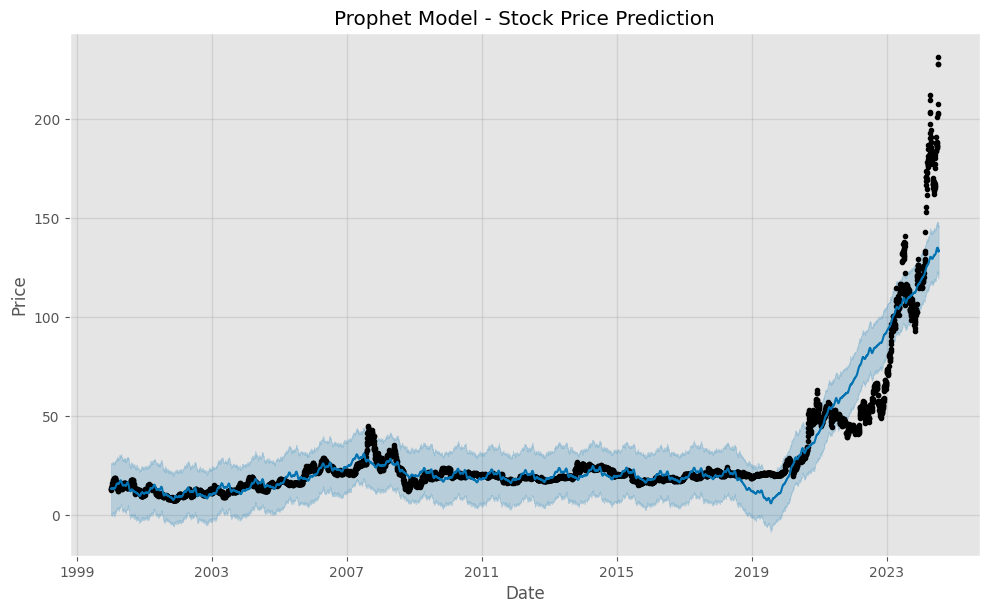

In [17]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# # 读取数据并设置索引
# df = pd.read_csv('/Users/tangjiahong/Dropbox/Pytorch/stock_env/stock_predict/1513_stock_data.csv')
# df.columns = df.columns.str.strip()
# df.set_index('Date', inplace=True)
# df.index = pd.to_datetime(df.index)
# df.sort_index(inplace=True)

# Prophet要求数据列名为'ds'和'y'
prophet_df = df.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})

# 使用Prophet模型进行预测
model = Prophet()
model.fit(prophet_df)

# 预测未来5天
future = model.make_future_dataframe(periods=5)
forecast = model.predict(future)

# 可视化结果
fig = model.plot(forecast)
plt.title('Prophet Model - Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


# 縮短訓練範圍

/var/folders/td/m175xz391hd4h1j11qwz0vyc0000gn/T/ipykernel_13597/3621179819.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
14:14:53 - cmdstanpy - INFO - Chain [1] start processing
14:14:53 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/td/m175xz391hd4h1j11qwz0vyc0000gn/T/ipykernel_13597/3621179819.py:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_val.fillna(method='bfill', inplace=True)
/var/folders/td/m175xz391hd4h1j11qwz0vyc0000gn/T/ipykernel_13597/3621179819.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_val.fillna(method='ffill', inplace=True)
/opt/anaconda3/envs/stock_env/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarn

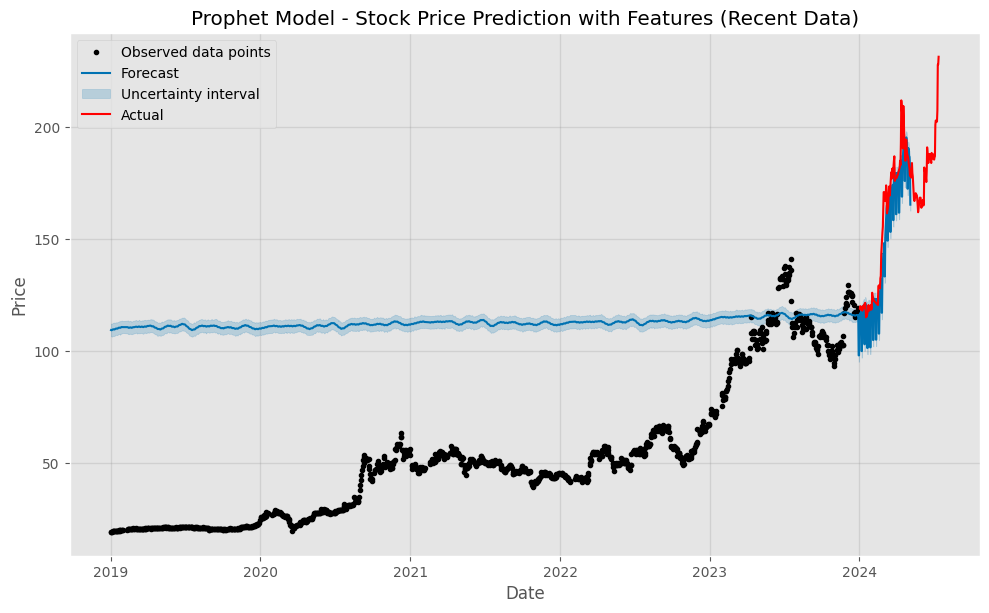

In [19]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# 讀取CSV文件
file_path = '1513_stock_data.csv'
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

# 定義計算RSI的函數
def compute_RSI(data, window=14):
    diff = data.diff(1).dropna()
    gain = (diff.where(diff > 0, 0)).rolling(window=window).mean()
    loss = (-diff.where(diff < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

# 增加特徵工程
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()
df['RSI'] = compute_RSI(df['Close'])

# 填充缺失值
df.fillna(method='bfill', inplace=True)

# 使用最近5年的數據進行訓練
train_df = df['2019-01-01':'2023-12-31']
val_df = df['2024-01-01':]

# Prophet要求數據列名為'ds'和'y'
prophet_train_df = train_df.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})

# 加入其他特徵
prophet_train_df['MA10'] = train_df['MA10'].reset_index(drop=True)
prophet_train_df['MA20'] = train_df['MA20'].reset_index(drop=True)
prophet_train_df['RSI'] = train_df['RSI'].reset_index(drop=True)

# 使用Prophet模型進行預測
model = Prophet(changepoint_prior_scale=0.05, seasonality_prior_scale=10)
model.add_regressor('MA10')
model.add_regressor('MA20')
model.add_regressor('RSI')
model.fit(prophet_train_df)

# 預測驗證集
future_val = model.make_future_dataframe(periods=len(val_df), freq='D')
future_val = future_val.merge(val_df[['MA10', 'MA20', 'RSI']], left_on='ds', right_index=True, how='left')
future_val.fillna(method='bfill', inplace=True)
future_val.fillna(method='ffill', inplace=True)

# 預測
forecast_val = model.predict(future_val)

# 可視化結果
fig = model.plot(forecast_val)
plt.plot(val_df.index, val_df['Close'], 'r', label='Actual')
plt.legend()
plt.title('Prophet Model - Stock Price Prediction with Features (Recent Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


/var/folders/td/m175xz391hd4h1j11qwz0vyc0000gn/T/ipykernel_13597/1967217409.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
14:35:20 - cmdstanpy - INFO - Chain [1] start processing
14:35:20 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/td/m175xz391hd4h1j11qwz0vyc0000gn/T/ipykernel_13597/1967217409.py:57: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_val.fillna(method='bfill', inplace=True)
/var/folders/td/m175xz391hd4h1j11qwz0vyc0000gn/T/ipykernel_13597/1967217409.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_val.fillna(method='ffill', inplace=True)
/opt/anaconda3/envs/stock_env/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarn

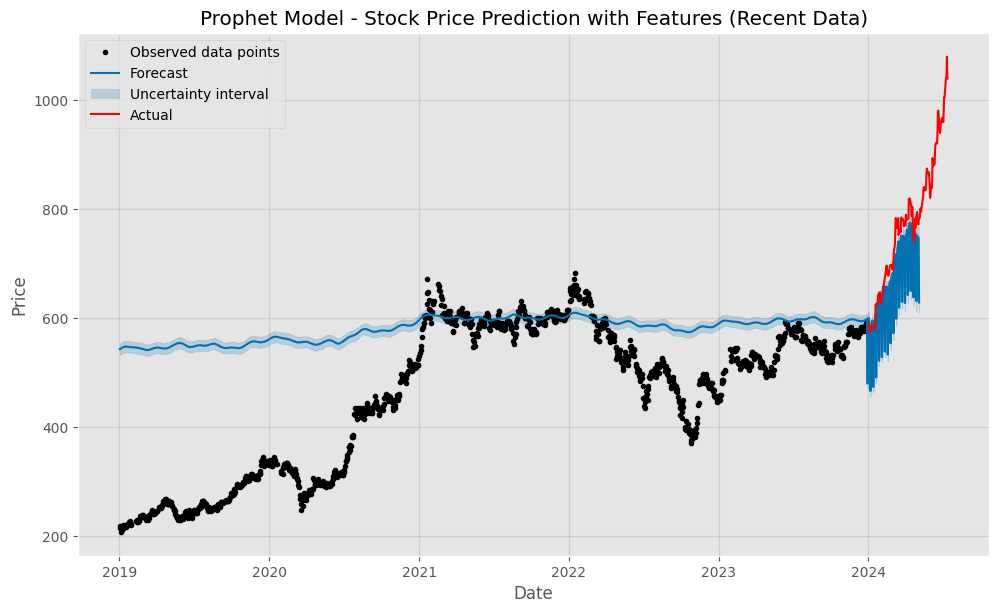

In [33]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# 讀取CSV文件
file_path = '2330_stock_data.csv'
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

# 定義計算RSI的函數
def compute_RSI(data, window=14):
    diff = data.diff(1).dropna()
    gain = (diff.where(diff > 0, 0)).rolling(window=window).mean()
    loss = (-diff.where(diff < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

# 增加特徵工程
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()
df['RSI'] = compute_RSI(df['Close'])
df['Volume_MA10'] = df['Volume'].rolling(window=10).mean()
df['Volume_MA20'] = df['Volume'].rolling(window=20).mean()

# 填充缺失值
df.fillna(method='bfill', inplace=True)

# 使用最近5年的數據進行訓練
train_df = df['2019-01-01':'2023-12-31']
val_df = df['2024-01-01':]

# Prophet要求數據列名為'ds'和'y'
prophet_train_df = train_df.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})

# 加入其他特徵
prophet_train_df['MA10'] = train_df['MA10'].reset_index(drop=True)
prophet_train_df['MA20'] = train_df['MA20'].reset_index(drop=True)
prophet_train_df['RSI'] = train_df['RSI'].reset_index(drop=True)
prophet_train_df['Volume_MA10'] = train_df['Volume_MA10'].reset_index(drop=True)
prophet_train_df['Volume_MA20'] = train_df['Volume_MA20'].reset_index(drop=True)

# 使用Prophet模型進行預測
model = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=10)
model.add_regressor('MA10')
model.add_regressor('MA20')
model.add_regressor('RSI')
model.add_regressor('Volume_MA10')
model.add_regressor('Volume_MA20')
model.fit(prophet_train_df)

# 預測驗證集
future_val = model.make_future_dataframe(periods=len(val_df), freq='D')
future_val = future_val.merge(val_df[['MA10', 'MA20', 'RSI', 'Volume_MA10', 'Volume_MA20']], left_on='ds', right_index=True, how='left')
future_val.fillna(method='bfill', inplace=True)
future_val.fillna(method='ffill', inplace=True)

# 預測
forecast_val = model.predict(future_val)

# 可視化結果
fig = model.plot(forecast_val)
plt.plot(val_df.index, val_df['Close'], 'r', label='Actual')
plt.legend()
plt.title('Prophet Model - Stock Price Prediction with Features (Recent Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


# LSTM

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
X_train shape: (4830, 60, 4), y_train shape: (4830,)
X_test shape: (1163, 60, 4), y_test shape: (1163,)
Epoch 1/100


/var/folders/td/m175xz391hd4h1j11qwz0vyc0000gn/T/ipykernel_13597/3109359650.py:50: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - loss: 0.0303 - val_loss: 0.0068
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0015 - val_loss: 9.3415e-04
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0013 - val_loss: 7.9158e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.0011 - val_loss: 7.5588e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0011 - val_loss: 5.5893e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 9.7520e-04 - val_loss: 3.7247e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 8.9458e-04 - val_loss: 7.8694e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 8.4555e-04 - val_loss: 3.3341e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 8.1994e-04 - val_loss: 3.1258e-04
Epoch

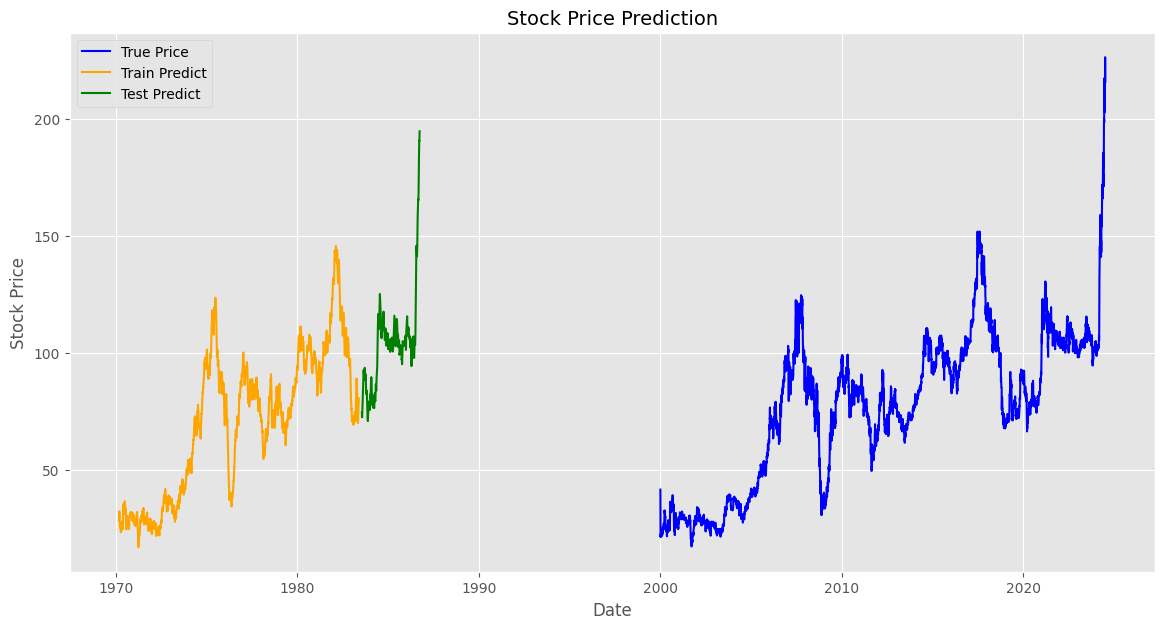

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# 檢查 GPU 是否可用
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"GPUs available: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found")

# 使用混合精度訓練
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# 設置 Matplotlib 風格
plt.style.use('ggplot')

# 讀取數據
df = pd.read_csv('2317_stock_data.csv')
df.columns = df.columns.str.strip()  # 去除列名中的多餘空格
df['Date'] = pd.to_datetime(df['Date'])  # 確保 'Date' 列為日期格式
df.set_index('Date', inplace=True)
df = df[['Close']]  # 只取收盤價

# 增加特徵工程
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()

# 相對強弱指數 (RSI)
def compute_RSI(data, window=14):
    diff = data.diff(1).dropna()
    gain = (diff.where(diff > 0, 0)).rolling(window=window).mean()
    loss = (-diff.where(diff < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

df['RSI'] = compute_RSI(df['Close'])

# 填充缺失值
df.fillna(method='bfill', inplace=True)

# 正規化數據
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# 構建訓練和測試數據集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), :])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 確認數據集形狀
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

# 重塑數據以符合 LSTM 的輸入要求 [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# 構建 LSTM 模型
model = Sequential()
model.add(Input(shape=(time_step, X_train.shape[2])))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(50, return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(25))
model.add(Dense(1))

# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 設置早停法
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 訓練模型
history = model.fit(X_train, y_train, batch_size=256, epochs=100, validation_split=0.2, callbacks=[early_stop])

# 預測
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反向正規化數據
train_predict = scaler.inverse_transform(np.concatenate([train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate([test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]

# 計算評估指標
train_rmse = np.sqrt(mean_squared_error(df['Close'][time_step:train_size], train_predict))
test_rmse = np.sqrt(mean_squared_error(df['Close'][train_size + time_step:], test_predict))
train_mae = mean_absolute_error(df['Close'][time_step:train_size], train_predict)
test_mae = mean_absolute_error(df['Close'][train_size + time_step:], test_predict)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# 可視化結果
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='True Price', color='blue', linewidth=1.5)
train_plot = np.empty_like(df['Close'])
train_plot[:] = np.nan
train_plot[time_step:len(train_predict)+time_step] = train_predict
plt.plot(train_plot, label='Train Predict', color='orange', linewidth=1.5)

test_plot = np.empty_like(df['Close'])
test_plot[:] = np.nan
test_plot[len(train_predict)+(time_step*2):len(train_predict)+(time_step*2)+len(test_predict)] = test_predict
plt.plot(test_plot, label='Test Predict', color='green', linewidth=1.5)

plt.title('Stock Price Prediction', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


# 只取2020年後的資料，包含太多舊的數據

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
X_train shape: (820, 60, 4), y_train shape: (820,)
X_test shape: (160, 60, 4), y_test shape: (160,)
Epoch 1/100


/var/folders/td/m175xz391hd4h1j11qwz0vyc0000gn/T/ipykernel_13597/4150113433.py:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 817ms/step - loss: 0.0541 - val_loss: 0.0192
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - loss: 0.0183 - val_loss: 8.8613e-04
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.0048 - val_loss: 0.0075
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0080 - val_loss: 0.0020
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0032 - val_loss: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0040 - val_loss: 0.0015
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0039 - val_loss: 3.9341e-04
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0024 - val_loss: 3.5635e-04
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0021 - val_loss: 5.2947e-04
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss:

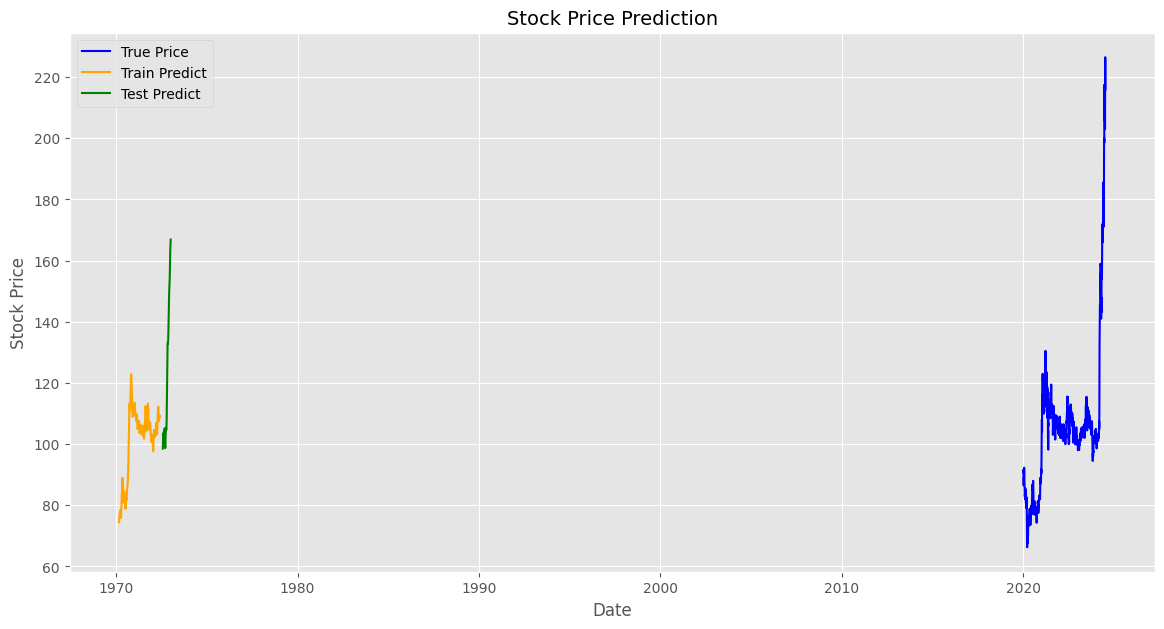

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# 檢查 GPU 是否可用
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"GPUs available: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found")

# 使用混合精度訓練
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# 設置 Matplotlib 風格
plt.style.use('ggplot')

# 讀取數據
df = pd.read_csv('2317_stock_data.csv')
df.columns = df.columns.str.strip()  # 去除列名中的多餘空格
df['Date'] = pd.to_datetime(df['Date'])  # 確保 'Date' 列為日期格式
df.set_index('Date', inplace=True)
df = df[df.index >= '2020-01-01']  # 只提取從2020年開始的數據
df = df[['Close']]  # 只取收盤價

# 增加特徵工程
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()

# 相對強弱指數 (RSI)
def compute_RSI(data, window=14):
    diff = data.diff(1).dropna()
    gain = (diff.where(diff > 0, 0)).rolling(window=window).mean()
    loss = (-diff.where(diff < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

df['RSI'] = compute_RSI(df['Close'])

# 填充缺失值
df.fillna(method='bfill', inplace=True)

# 正規化數據
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# 構建訓練和測試數據集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), :])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 確認數據集形狀
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

# 重塑數據以符合 LSTM 的輸入要求 [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# 構建 LSTM 模型
model = Sequential()
model.add(Input(shape=(time_step, X_train.shape[2])))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(50, return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(25))
model.add(Dense(1))

# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 設置早停法
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 訓練模型
history = model.fit(X_train, y_train, batch_size=256, epochs=100, validation_split=0.2, callbacks=[early_stop])

# 預測
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反向正規化數據
train_predict = scaler.inverse_transform(np.concatenate([train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate([test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]

# 計算評估指標
train_rmse = np.sqrt(mean_squared_error(df['Close'][time_step:train_size], train_predict))
test_rmse = np.sqrt(mean_squared_error(df['Close'][train_size + time_step:], test_predict))
train_mae = mean_absolute_error(df['Close'][time_step:train_size], train_predict)
test_mae = mean_absolute_error(df['Close'][train_size + time_step:], test_predict)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# 可視化結果
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='True Price', color='blue', linewidth=1.5)
train_plot = np.empty_like(df['Close'])
train_plot[:] = np.nan
train_plot[time_step:len(train_predict)+time_step] = train_predict
plt.plot(train_plot, label='Train Predict', color='orange', linewidth=1.5)

test_plot = np.empty_like(df['Close'])
test_plot[:] = np.nan
test_plot[len(train_predict)+(time_step*2):len(train_predict)+(time_step*2)+len(test_predict)] = test_predict
plt.plot(test_plot, label='Test Predict', color='green', linewidth=1.5)

plt.title('Stock Price Prediction', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


# 歷史數據分析

Monthly Mean Return: 0.00042471872849518056, Monthly Volatility: 0.003633601208156763
Weekly Mean Return: 0.0003950531473781659, Weekly Volatility: 0.007712306504987495
Monthly Win Rate: 52.21%
Weekly Win Rate: 53.99%


/var/folders/td/m175xz391hd4h1j11qwz0vyc0000gn/T/ipykernel_16465/2463288311.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_return = df['Return'].resample('M').mean()


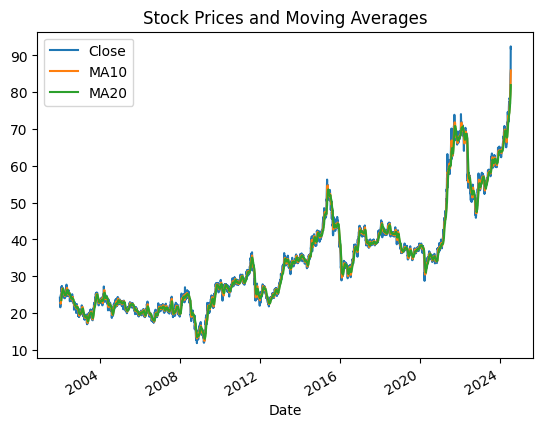

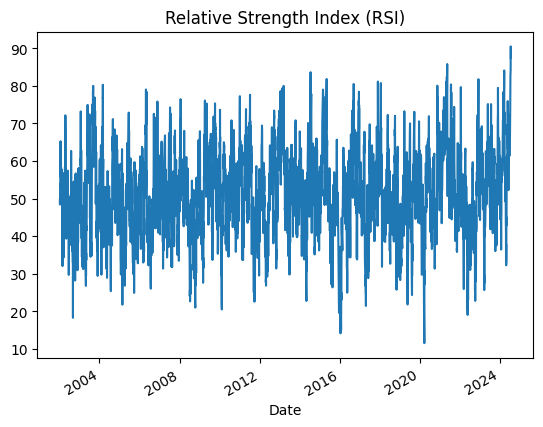

15:20:54 - cmdstanpy - INFO - Chain [1] start processing
15:20:55 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/envs/stock_env/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/stock_env/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


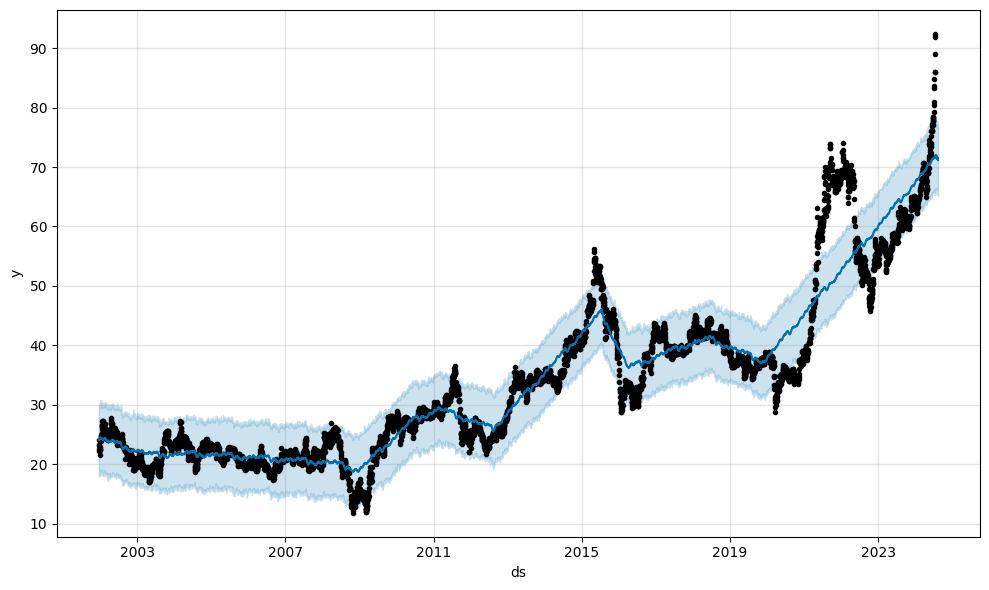

/var/folders/td/m175xz391hd4h1j11qwz0vyc0000gn/T/ipykernel_16465/2463288311.py:71: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_return = df['Return'].resample('M').mean()
/var/folders/td/m175xz391hd4h1j11qwz0vyc0000gn/T/ipykernel_16465/2463288311.py:72: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_volatility = df['Return'].resample('M').std()
/var/folders/td/m175xz391hd4h1j11qwz0vyc0000gn/T/ipykernel_16465/2463288311.py:80: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_win_rate = (df['Return'].resample('M').apply(lambda x: (x > 0).mean()) * 100).mean()


Monthly Mean Return: 0.00042471872849518056, Monthly Volatility: 0.016011926963160575
Weekly Mean Return: 0.0003950531473781659, Weekly Volatility: 0.014929906195288764
Monthly Win Rate: 47.31105941603863%
Weekly Win Rate: 47.15307582260372%
Standard Deviation: 0.017658217218894993
Value at Risk (95% confidence): -0.027108447954138238
Win Rate: 0.7207815275310835


In [37]:
import pandas as pd
import numpy as np
from prophet import Prophet
import talib
import matplotlib.pyplot as plt

# 读取数据并修正列名
df = pd.read_csv('2881_stock_data.csv')
df.columns = df.columns.str.strip()  # 去除列名两端的空格

# 将Date列设置为日期格式并设置为索引
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 计算每日收益率
df['Return'] = df['Close'].pct_change()

# 计算每月和每周的收益率
monthly_return = df['Return'].resample('M').mean()
weekly_return = df['Return'].resample('W').mean()

# 计算平均收益率和波动性
monthly_mean = monthly_return.mean()
monthly_volatility = monthly_return.std()
weekly_mean = weekly_return.mean()
weekly_volatility = weekly_return.std()

print(f'Monthly Mean Return: {monthly_mean}, Monthly Volatility: {monthly_volatility}')
print(f'Weekly Mean Return: {weekly_mean}, Weekly Volatility: {weekly_volatility}')

# 计算每月和每周收益为正的次数
monthly_positive = (monthly_return > 0).sum()
monthly_total = monthly_return.count()
monthly_win_rate = monthly_positive / monthly_total

weekly_positive = (weekly_return > 0).sum()
weekly_total = weekly_return.count()
weekly_win_rate = weekly_positive / weekly_total

print(f'Monthly Win Rate: {monthly_win_rate * 100:.2f}%')
print(f'Weekly Win Rate: {weekly_win_rate * 100:.2f}%')

# 计算技术指标
df['MA10'] = talib.SMA(df['Close'], timeperiod=10)
df['MA20'] = talib.SMA(df['Close'], timeperiod=20)
df['RSI'] = talib.RSI(df['Close'], timeperiod=14)

# 绘制技术指标
df[['Close', 'MA10', 'MA20']].plot(title='Stock Prices and Moving Averages')
plt.show()

df['RSI'].plot(title='Relative Strength Index (RSI)')
plt.show()

# Prophet模型需要的列名为'ds'和'y'
prophet_df = df[['Close']].reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})

# 训练 Prophet 模型
model = Prophet()
model.fit(prophet_df)

# 预测未来30天
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# 可视化结果
fig = model.plot(forecast)
plt.show()

# 计算统计数据
monthly_return = df['Return'].resample('M').mean()
monthly_volatility = df['Return'].resample('M').std()
weekly_return = df['Return'].resample('W').mean()
weekly_volatility = df['Return'].resample('W').std()

print(f'Monthly Mean Return: {monthly_return.mean()}, Monthly Volatility: {monthly_volatility.mean()}')
print(f'Weekly Mean Return: {weekly_return.mean()}, Weekly Volatility: {weekly_volatility.mean()}')

# 计算每月和每周的上涨概率
monthly_win_rate = (df['Return'].resample('M').apply(lambda x: (x > 0).mean()) * 100).mean()
weekly_win_rate = (df['Return'].resample('W').apply(lambda x: (x > 0).mean()) * 100).mean()

print(f'Monthly Win Rate: {monthly_win_rate}%')
print(f'Weekly Win Rate: {weekly_win_rate}%')

# 计算VaR
std_dev = np.std(df['Return'].dropna())
VaR_95 = np.percentile(df['Return'].dropna(), 5)

print(f'Standard Deviation: {std_dev}')
print(f'Value at Risk (95% confidence): {VaR_95}')

# 计算预测期间内上涨的天数
forecast['Trend'] = forecast['yhat'].diff()
up_days = forecast[forecast['Trend'] > 0].shape[0]

# 计算胜率
total_days = forecast.shape[0]
win_rate = up_days / total_days

print(f'Win Rate: {win_rate}')


In [38]:
import pandas as pd

# 读取数据并修正列标头
df = pd.read_csv('2881_stock_data.csv')
df.columns = df.columns.str.strip()  # 去除列标头中的空格
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 计算每日收益率
df['Return'] = df['Close'].pct_change()

# 计算每月和每周的收益率
monthly_return = df['Return'].resample('M').mean()
weekly_return = df['Return'].resample('W').mean()

# 计算平均收益率和波动性
monthly_mean = monthly_return.mean()
monthly_volatility = monthly_return.std()
weekly_mean = weekly_return.mean()
weekly_volatility = weekly_return.std()

# 计算每月和每周收益为正的次数
monthly_positive = (monthly_return > 0).sum()
monthly_total = monthly_return.count()
monthly_win_rate = monthly_positive / monthly_total

weekly_positive = (weekly_return > 0).sum()
weekly_total = weekly_return.count()
weekly_win_rate = weekly_positive / weekly_total

# 计算半年内和一年内的胜率
six_months_return = df['Return'].last('6M')
one_year_return = df['Return'].last('1Y')

six_months_positive = (six_months_return > 0).sum()
six_months_total = six_months_return.count()
six_months_win_rate = six_months_positive / six_months_total

one_year_positive = (one_year_return > 0).sum()
one_year_total = one_year_return.count()
one_year_win_rate = one_year_positive / one_year_total

# 将结果转换为百分比
results = {
    'Monthly Mean Return': f'{monthly_mean * 100:.2f}%',
    'Monthly Volatility': f'{monthly_volatility * 100:.2f}%',
    'Weekly Mean Return': f'{weekly_mean * 100:.2f}%',
    'Weekly Volatility': f'{weekly_volatility * 100:.2f}%',
    'Monthly Win Rate': f'{monthly_win_rate * 100:.2f}%',
    'Weekly Win Rate': f'{weekly_win_rate * 100:.2f}%',
    'Six Months Win Rate': f'{six_months_win_rate * 100:.2f}%',
    'One Year Win Rate': f'{one_year_win_rate * 100:.2f}%'
}

# 创建 DataFrame 并显示
results_df = pd.DataFrame(list(results.items()), columns=['Metric', 'Value'])
results_df.to_csv("2881_stock_performance_metrics.csv", index=False)
results_df


/var/folders/td/m175xz391hd4h1j11qwz0vyc0000gn/T/ipykernel_16465/658792914.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_return = df['Return'].resample('M').mean()
/var/folders/td/m175xz391hd4h1j11qwz0vyc0000gn/T/ipykernel_16465/658792914.py:32: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  six_months_return = df['Return'].last('6M')
/var/folders/td/m175xz391hd4h1j11qwz0vyc0000gn/T/ipykernel_16465/658792914.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  six_months_return = df['Return'].last('6M')
/var/folders/td/m175xz391hd4h1j11qwz0vyc0000gn/T/ipykernel_16465/658792914.py:33: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  one_year_return = df['Return'].last('1Y')
/var/folders/td/m175xz391hd4h

,Metric,Value
0,Monthly Mean Return,0.04%
1,Monthly Volatility,0.36%
2,Weekly Mean Return,0.04%
3,Weekly Volatility,0.77%
4,Monthly Win Rate,52.21%
5,Weekly Win Rate,53.99%
6,Six Months Win Rate,58.10%
7,One Year Win Rate,55.12%


# 自動化生成data、分析排名前五

In [42]:
import yfinance as yf
import pandas as pd
import numpy as np
from prophet import Prophet
import talib
import matplotlib.pyplot as plt

def get_stock_tickers():
    # 获取台湾50指数成分股列表
    tickers = ["2330.TW", "2317.TW", "2382.TW", "2303.TW", "1216.TW", "3711.TW", "1303.TW", "2002.TW", "1301.TW", "3231.TW",
               "3045.TW", "2542.TW", "2449.TW", "5388.TW", "2376.TW", "2603.TW", "3035.TW","2356.TW", "2357.TW", "2383.TW",
               "2360.TW", "2454.TW", "6505.TW", "2412.TW", "1301.TW", "1303.TW", "2308.TW", "2881.TW",
               "3017.TW", "3006.TW", "2408.TW", "2344.TW","8046.TW", "3037.TW", "2891.TW","2882.TW","2353.TW",
               "1513.TW", "2308.TW", "8996.TW", "6282.TW", "1795.TW", "2388.TW"]
    return tickers

def analyze_stock(ticker):
    # Download Historical Stock Data
    data = yf.download(ticker, start='2020-01-01', end='2024-07-15')
    if data.empty:
        return None, None
    
    data.to_csv(f'{ticker}_stock_data.csv')
    
    # Technical Analysis
    df = pd.read_csv(f'{ticker}_stock_data.csv')
    df.columns = df.columns.str.strip()  # Remove leading/trailing whitespace
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Calculate monthly returns
    monthly_return = df['Return'].resample('M').mean()

    # Calculate technical indicators
    df['MA10'] = talib.SMA(df['Close'], timeperiod=10)
    df['MA20'] = talib.SMA(df['Close'], timeperiod=20)
    df['RSI'] = talib.RSI(df['Close'], timeperiod=14)

    # Prepare data for Prophet model
    prophet_df = df[['Close']].reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})

    # Train Prophet model
    model = Prophet()
    model.fit(prophet_df)

    # Predict next 30 days
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)

    # Calculate win rate over forecast period
    forecast['Trend'] = forecast['yhat'].diff()
    up_days = forecast[forecast['Trend'] > 0].shape[0]
    total_days = forecast.shape[0]
    win_rate = up_days / total_days * 100

    # Calculate one month return
    one_month_return = df['Return'].last('1M').mean()

    return one_month_return, win_rate

# Automatically fetch stock tickers
stock_tickers = get_stock_tickers()

results = []

for ticker in stock_tickers:  # Analyzing the tickers for demonstration purposes
    one_month_return, win_rate = analyze_stock(ticker)
    if one_month_return is not None:
        results.append({'Ticker': ticker, 'One Month Return': one_month_return, 'Win Rate': win_rate})

# Create DataFrame from results and sort by One Month Return
results_df = pd.DataFrame(results)
results_df['One Month Return'] = results_df['One Month Return'] * 100  # Convert to percentage
results_df['Win Rate'] = results_df['Win Rate']  # Already in percentage
top_5_stocks = results_df.sort_values(by='One Month Return', ascending=False).head(5)

# Save results to CSV
top_5_stocks.to_csv("top_5_bullish_stocks.csv", index=False)
print(top_5_stocks)


[*********************100%%**********************]  1 of 1 completed
/var/folders/td/m175xz391hd4h1j11qwz0vyc0000gn/T/ipykernel_16465/3506887632.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_return = df['Return'].resample('M').mean()
15:48:08 - cmdstanpy - INFO - Chain [1] start processing
15:48:08 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/td/m175xz391hd4h1j11qwz0vyc0000gn/T/ipykernel_16465/3506887632.py:60: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  one_month_return = df['Return'].last('1M').mean()
/var/folders/td/m175xz391hd4h1j11qwz0vyc0000gn/T/ipykernel_16465/3506887632.py:60: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  one_month_return = df['Return'].last('1M').mean()
[*********************100%%**********************]  1 of 1 completed
/var/folders/td/m

     Ticker  One Month Return   Win Rate
37  1513.TW          2.159648  60.176991
11  2542.TW          1.575629  54.601770
27  2881.TW          1.494967  63.716814
35  2882.TW          1.102296  58.318584
38  2308.TW          0.877988  56.814159


/var/folders/td/m175xz391hd4h1j11qwz0vyc0000gn/T/ipykernel_16465/3506887632.py:60: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  one_month_return = df['Return'].last('1M').mean()
/var/folders/td/m175xz391hd4h1j11qwz0vyc0000gn/T/ipykernel_16465/3506887632.py:60: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  one_month_return = df['Return'].last('1M').mean()


# 新增每半年、每年的收益和勝率、前五名空頭

In [47]:
import yfinance as yf
import pandas as pd
import numpy as np
from prophet import Prophet
import talib
import matplotlib.pyplot as plt

def get_stock_tickers():
    # 获取台湾50指数成分股列表
    tickers = ["2330.TW", "2317.TW", "2382.TW", "2303.TW", "1216.TW", "3711.TW", "1303.TW", "2002.TW", "1301.TW", "3231.TW",
               "3045.TW", "2542.TW", "2449.TW", "5388.TW", "2376.TW", "2603.TW", "3035.TW","2356.TW", "2357.TW", "2383.TW",
               "2360.TW", "2454.TW", "6505.TW", "2412.TW", "1301.TW", "1303.TW", "2308.TW", "2881.TW",
               "3017.TW", "3006.TW", "2408.TW", "2344.TW","8046.TW", "3037.TW", "2891.TW","2882.TW","2353.TW",
               "1513.TW", "2308.TW", "8996.TW", "6282.TW", "1795.TW", "2388.TW"]
    return tickers

def analyze_stock(ticker, end_date):
    # Download Historical Stock Data
    data = yf.download(ticker, start='2020-01-01', end=end_date)
    if data.empty:
        return None
    
    data.to_csv(f'{ticker}_stock_data.csv')
    
    # Technical Analysis
    df = pd.read_csv(f'{ticker}_stock_data.csv')
    df.columns = df.columns.str.strip()  # Remove leading/trailing whitespace
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Calculate monthly returns
    monthly_return = df['Return'].resample('ME').mean()

    # Calculate technical indicators
    df['MA10'] = talib.SMA(df['Close'], timeperiod=10)
    df['MA20'] = talib.SMA(df['Close'], timeperiod=20)
    df['RSI'] = talib.RSI(df['Close'], timeperiod=14)

    # Prepare data for Prophet model
    prophet_df = df[['Close']].reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})

    # Train Prophet model
    model = Prophet()
    model.fit(prophet_df)

    # Predict next 30 days
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)

    # Calculate win rate over forecast period
    forecast['Trend'] = forecast['yhat'].diff()
    up_days = forecast[forecast['Trend'] > 0].shape[0]
    total_days = forecast.shape[0]
    win_rate = up_days / total_days * 100

    # Calculate returns and win rates
    end_date = pd.to_datetime(end_date)
    one_month_return = df.loc[end_date - pd.DateOffset(months=1):end_date, 'Return'].mean() * 100
    six_months_return = df.loc[end_date - pd.DateOffset(months=6):end_date, 'Return'].mean() * 100
    one_year_return = df.loc[end_date - pd.DateOffset(years=1):end_date, 'Return'].mean() * 100

    six_months_positive = (df.loc[end_date - pd.DateOffset(months=6):end_date, 'Return'] > 0).sum()
    six_months_total = df.loc[end_date - pd.DateOffset(months=6):end_date, 'Return'].count()
    six_months_win_rate = six_months_positive / six_months_total * 100

    one_year_positive = (df.loc[end_date - pd.DateOffset(years=1):end_date, 'Return'] > 0).sum()
    one_year_total = df.loc[end_date - pd.DateOffset(years=1):end_date, 'Return'].count()
    one_year_win_rate = one_year_positive / one_year_total * 100

    return {
        'Ticker': ticker,
        'One Month Return': one_month_return,
        'Six Months Return': six_months_return,
        'One Year Return': one_year_return,
        'One Month Win Rate': win_rate,
        'Six Months Win Rate': six_months_win_rate,
        'One Year Win Rate': one_year_win_rate
    }

# Automatically fetch stock tickers
stock_tickers = get_stock_tickers()

# Define the end date for analysis
end_date = '2024-07-15'  # 修改这里的日期为当前日期

results = []

for ticker in stock_tickers:
    result = analyze_stock(ticker, end_date)
    if result:
        results.append(result)

# Create DataFrame from results and sort by One Month Return
results_df = pd.DataFrame(results)
top_10_bullish = results_df.sort_values(by='One Month Return', ascending=False).head(10)
top_10_bearish = results_df.sort_values(by='One Month Return').head(10)

# Save results to CSV
top_10_bullish.to_csv("top_10_bullish_stocks.csv", index=False)
top_10_bearish.to_csv("top_10_bearish_stocks.csv", index=False)

print("Top 10 Bullish Stocks:")
print(top_10_bullish)

print("\nTop 10 Bearish Stocks:")
print(top_10_bearish)


[*********************100%%**********************]  1 of 1 completed


16:33:24 - cmdstanpy - INFO - Chain [1] start processing
16:33:24 - cmdstanpy - INFO - Chain [1] done processing
[*********************100%%**********************]  1 of 1 completed
16:33:25 - cmdstanpy - INFO - Chain [1] start processing
16:33:25 - cmdstanpy - INFO - Chain [1] done processing
[*********************100%%**********************]  1 of 1 completed
16:33:25 - cmdstanpy - INFO - Chain [1] start processing
16:33:25 - cmdstanpy - INFO - Chain [1] done processing
[*********************100%%**********************]  1 of 1 completed
16:33:25 - cmdstanpy - INFO - Chain [1] start processing
16:33:26 - cmdstanpy - INFO - Chain [1] done processing
[*********************100%%**********************]  1 of 1 completed
16:33:26 - cmdstanpy - INFO - Chain [1] start processing
16:33:26 - cmdstanpy - INFO - Chain [1] done processing
[*********************100%%**********************]  1 of 1 completed
16:33:26 - cmdstanpy - INFO - Chain [1] start processing
16:33:26 - cmdstanpy - INFO - Ch

Top 10 Bullish Stocks:
     Ticker  One Month Return  Six Months Return  One Year Return  \
12  2449.TW          1.486970           0.486831         0.350956   
37  1513.TW          1.008482           0.606622         0.257938   
38  2308.TW          0.911851           0.331869         0.073195   
26  2308.TW          0.911851           0.331869         0.073195   
27  2881.TW          0.902997           0.312205         0.184587   
11  2542.TW          0.841371           0.368309         0.192846   
20  2360.TW          0.640544           0.375465         0.081393   
35  2882.TW          0.622964           0.341359         0.171899   
0   2330.TW          0.622506           0.510505         0.246418   
2   2382.TW          0.621771           0.334349         0.259962   

    One Month Win Rate  Six Months Win Rate  One Year Win Rate  
12           59.115044            48.305085          48.559671  
37           60.176991            50.000000          46.090535  
38           56.814159

In [50]:
import yfinance as yf
import pandas as pd
import numpy as np
from prophet import Prophet
import talib
import matplotlib.pyplot as plt

def get_stock_tickers():
    # 获取台湾50指数成分股列表
    tickers = ["2330.TW", "2317.TW", "2382.TW", "2303.TW", "1216.TW", "3711.TW", "1303.TW", "2002.TW", "1301.TW", "3231.TW",
               "3045.TW", "2542.TW", "2449.TW", "5388.TW", "2376.TW", "2603.TW", "3035.TW","2356.TW", "2357.TW", "2383.TW",
               "2360.TW", "2454.TW", "6505.TW", "2412.TW", "1301.TW", "1303.TW", "2308.TW", "2881.TW",
               "3017.TW", "3006.TW", "2408.TW", "2344.TW","8046.TW", "3037.TW", "2891.TW","2882.TW","2353.TW",
               "1513.TW", "2308.TW", "8996.TW", "6282.TW", "1795.TW", "2388.TW"]
    return tickers


def analyze_stock(ticker):
    # Download Historical Stock Data
    data = yf.download(ticker, start='2020-01-01', end='2024-07-15')
    if data.empty:
        return None, None, None, None, None, None, None
    
    data.to_csv(f'{ticker}_stock_data.csv')
    
    # Technical Analysis
    df = pd.read_csv(f'{ticker}_stock_data.csv')
    df.columns = df.columns.str.strip()  # Remove leading/trailing whitespace
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Calculate win rates
    monthly_win_rate = (df['Return'].resample('ME').apply(lambda x: (x > 0).mean()) * 100).mean()
    weekly_win_rate = (df['Return'].resample('W').apply(lambda x: (x > 0).mean()) * 100).mean()
    six_months_win_rate = (df.loc[df.index[-1] - pd.DateOffset(months=6):, 'Return'] > 0).mean() * 100
    one_year_win_rate = (df.loc[df.index[-1] - pd.DateOffset(years=1):, 'Return'] > 0).mean() * 100

    # Calculate technical indicators
    df['MA10'] = talib.SMA(df['Close'], timeperiod=10)
    df['MA20'] = talib.SMA(df['Close'], timeperiod=20)
    df['RSI'] = talib.RSI(df['Close'], timeperiod=14)

    # Prepare data for Prophet model
    prophet_df = df[['Close']].reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})

    # Train Prophet model
    model = Prophet()
    model.fit(prophet_df)

    # Predict next 30 days
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)

    # Calculate win rate over forecast period
    forecast['Trend'] = forecast['yhat'].diff()
    up_days = forecast[forecast['Trend'] > 0].shape[0]
    total_days = forecast.shape[0]
    win_rate = up_days / total_days * 100

    # Calculate returns
    one_month_return = df.loc[df.index[-1] - pd.DateOffset(months=1):, 'Return'].mean() * 100
    six_months_return = df.loc[df.index[-1] - pd.DateOffset(months=6):, 'Return'].mean() * 100
    one_year_return = df.loc[df.index[-1] - pd.DateOffset(years=1):, 'Return'].mean() * 100

    return one_month_return, six_months_return, one_year_return, monthly_win_rate, weekly_win_rate, six_months_win_rate, one_year_win_rate

# Automatically fetch stock tickers
stock_tickers = get_stock_tickers()

results = []

for ticker in stock_tickers:  # Analyzing the tickers for demonstration purposes
    one_month_return, six_months_return, one_year_return, monthly_win_rate, weekly_win_rate, six_months_win_rate, one_year_win_rate = analyze_stock(ticker)
    if one_month_return is not None:
        results.append({
            'Ticker': ticker, 
            'One Month Return': f'{one_month_return:.2f}%', 
            'Six Months Return': f'{six_months_return:.2f}%', 
            'One Year Return': f'{one_year_return:.2f}%', 
            'Monthly Win Rate': f'{monthly_win_rate:.2f}%', 
            'Weekly Win Rate': f'{weekly_win_rate:.2f}%', 
            'Six Months Win Rate': f'{six_months_win_rate:.2f}%', 
            'One Year Win Rate': f'{one_year_win_rate:.2f}%'
        })

# Create DataFrame from results and sort by One Month Return
results_df = pd.DataFrame(results)

top_10_stocks = results_df.sort_values(by='One Month Return', ascending=False).head(10)
bottom_10_stocks = results_df.sort_values(by='One Month Return', ascending=True).head(10)

# Save results to CSV
top_10_stocks.to_csv("top_10_bullish_stocks2.csv", index=False)
bottom_10_stocks.to_csv("bottom_10_bearish_stocks2.csv", index=False)

print(top_10_stocks)
print(bottom_10_stocks)


[*********************100%%**********************]  1 of 1 completed


16:54:29 - cmdstanpy - INFO - Chain [1] start processing
16:54:29 - cmdstanpy - INFO - Chain [1] done processing
[*********************100%%**********************]  1 of 1 completed
16:54:29 - cmdstanpy - INFO - Chain [1] start processing
16:54:29 - cmdstanpy - INFO - Chain [1] done processing
[*********************100%%**********************]  1 of 1 completed
16:54:30 - cmdstanpy - INFO - Chain [1] start processing
16:54:30 - cmdstanpy - INFO - Chain [1] done processing
[*********************100%%**********************]  1 of 1 completed
16:54:30 - cmdstanpy - INFO - Chain [1] start processing
16:54:30 - cmdstanpy - INFO - Chain [1] done processing
[*********************100%%**********************]  1 of 1 completed
16:54:30 - cmdstanpy - INFO - Chain [1] start processing
16:54:31 - cmdstanpy - INFO - Chain [1] done processing
[*********************100%%**********************]  1 of 1 completed
16:54:31 - cmdstanpy - INFO - Chain [1] start processing
16:54:31 - cmdstanpy - INFO - Ch

     Ticker One Month Return Six Months Return One Year Return  \
12  2449.TW            1.71%             0.46%           0.35%   
37  1513.TW            1.20%             0.61%           0.27%   
11  2542.TW            0.97%             0.36%           0.19%   
38  2308.TW            0.96%             0.33%           0.08%   
26  2308.TW            0.96%             0.33%           0.08%   
1   2317.TW            0.83%             0.68%           0.31%   
2   2382.TW            0.79%             0.36%           0.31%   
27  2881.TW            0.76%             0.31%           0.19%   
0   2330.TW            0.73%             0.50%           0.25%   
16  3035.TW            0.66%            -0.14%           0.17%   

   Monthly Win Rate Weekly Win Rate Six Months Win Rate One Year Win Rate  
12           49.58%          49.40%              47.90%            48.37%  
37           48.98%          49.15%              50.42%            46.34%  
11           48.87%          48.65%          

# 將結果分別放在不同資料夾 (改base_folder、end date、os.makedirs、to csv)

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from prophet import Prophet
import talib
import matplotlib.pyplot as plt
import os
import requests
from bs4 import BeautifulSoup

def get_stock_tickers():
    tickers = ["00929.TW", "00712.TW", "00637L.TW", "2884.TW", "00650L.TW", "2886.TW", "2892.TW", 
               "00893.TW", "00706L.TW", "2880.TW", "00830.TW", "00900.TW", "0050.TW", "5880.TW", 
               "00673R.TW", "00715L.TW", "00633L.TW", "2812.TW", "00885.TW", "00895.TW", "00662.TW", 
               "00888.TW", "00646.TW", "00903.TW", "00683L.TW", "00642U.TW", "00770.TW", "00762.TW", 
               "0051.TW", "00851.TW", "006203.TW", "00660.TW"]
    return tickers

def fetch_news(ticker):
    url = f"https://tw.stock.yahoo.com/q/h?s={ticker}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    news = soup.find_all('li', class_='js-stream-content')

    news_list = []
    for item in news[:5]:  # Get top 5 news
        title = item.find('h3').text
        link = item.find('a')['href']
        news_list.append({'Title': title, 'Link': link})
    
    return news_list

def fetch_institutional_data(ticker):
    url = f"https://tw.stock.yahoo.com/q/ts?s={ticker}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    tables = soup.find_all('table')

    if len(tables) < 2:
        return None
    
    df = pd.read_html(str(tables[1]))[0]
    df.columns = ['Date', 'Institution', 'Buy', 'Sell', 'Net']
    return df

def fetch_foreign_holdings(ticker):
    url = f"https://tw.stock.yahoo.com/d/s/major_{ticker.split('.')[0]}.html"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    tables = soup.find_all('table')

    if len(tables) < 2:
        return None

    df = pd.read_html(str(tables[1]))[0]
    df.columns = ['Date', 'Foreign Holdings', 'Shares', 'Percentage']
    return df

def analyze_stock(ticker):
    base_folder = f'results/{ticker}'
    os.makedirs(base_folder, exist_ok=True)
    
    # Download Historical Stock Data
    data = yf.download(ticker, start='2020-01-01', end='2024-07-15')
    if data.empty:
        return None, None, None, None, None, None, None
    
    data.to_csv(f'{base_folder}/{ticker}_stock_data.csv')
    
    # Technical Analysis
    df = pd.read_csv(f'{base_folder}/{ticker}_stock_data.csv')
    df.columns = df.columns.str.strip()  # Remove leading/trailing whitespace
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Calculate win rates
    monthly_win_rate = (df['Return'].resample('ME').apply(lambda x: (x > 0).mean()) * 100).mean()
    weekly_win_rate = (df['Return'].resample('W').apply(lambda x: (x > 0).mean()) * 100).mean()
    six_months_win_rate = (df.loc[df.index[-1] - pd.DateOffset(months=6):, 'Return'] > 0).mean() * 100
    one_year_win_rate = (df.loc[df.index[-1] - pd.DateOffset(years=1):, 'Return'] > 0).mean() * 100

    # Calculate technical indicators
    df['MA10'] = talib.SMA(df['Close'], timeperiod=10)
    df['MA20'] = talib.SMA(df['Close'], timeperiod=20)
    df['RSI'] = talib.RSI(df['Close'], timeperiod=14)

    # Plot technical indicators
    plt.figure(figsize=(14, 7))
    plt.plot(df['Close'], label='Close Price')
    plt.plot(df['MA10'], label='MA10')
    plt.plot(df['MA20'], label='MA20')
    plt.title(f'{ticker} - Close Price and Moving Averages')
    plt.legend()
    plt.savefig(f'{base_folder}/{ticker}_technical_analysis.png')
    plt.close()
    
    plt.figure(figsize=(14, 7))
    plt.plot(df['RSI'], label='RSI')
    plt.title(f'{ticker} - RSI')
    plt.legend()
    plt.savefig(f'{base_folder}/{ticker}_RSI.png')
    plt.close()

    # Prepare data for Prophet model
    prophet_df = df[['Close']].reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})

    # Train Prophet model
    model = Prophet()
    model.fit(prophet_df)

    # Predict next 30 days
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)

    # Plot Prophet forecast
    fig = model.plot(forecast)
    plt.title(f'{ticker} - Prophet Forecast')
    plt.savefig(f'{base_folder}/{ticker}_prophet_forecast.png')
    plt.close()

    # Calculate win rate over forecast period
    forecast['Trend'] = forecast['yhat'].diff()
    up_days = forecast[forecast['Trend'] > 0].shape[0]
    total_days = forecast.shape[0]
    win_rate = up_days / total_days * 100

    # Calculate returns
    one_month_return = df.loc[df.index[-1] - pd.DateOffset(months=1):, 'Return'].mean() * 100
    six_months_return = df.loc[df.index[-1] - pd.DateOffset(months=6):, 'Return'].mean() * 100
    one_year_return = df.loc[df.index[-1] - pd.DateOffset(years=1):, 'Return'].mean() * 100

    # Fetch news, institutional data, and foreign holdings
    news_list = fetch_news(ticker)
    institutional_data = fetch_institutional_data(ticker)
    foreign_holdings = fetch_foreign_holdings(ticker)

    if news_list:
        pd.DataFrame(news_list).to_csv(f'{base_folder}/{ticker}_news.csv', index=False)

    if institutional_data is not None:
        institutional_data.to_csv(f'{base_folder}/{ticker}_institutional_data.csv', index=False)

    if foreign_holdings is not None:
        foreign_holdings.to_csv(f'{base_folder}/{ticker}_foreign_holdings.csv', index=False)

    return one_month_return, six_months_return, one_year_return, monthly_win_rate, weekly_win_rate, six_months_win_rate, one_year_win_rate

# Automatically fetch stock tickers
stock_tickers = get_stock_tickers()

results = []

for ticker in stock_tickers:  # Analyzing the tickers for demonstration purposes
    one_month_return, six_months_return, one_year_return, monthly_win_rate, weekly_win_rate, six_months_win_rate, one_year_win_rate = analyze_stock(ticker)
    if one_month_return is not None:
        results.append({
            'Ticker': ticker, 
            'One Month Return': f'{one_month_return:.2f}%', 
            'Six Months Return': f'{six_months_return:.2f}%', 
            'One Year Return': f'{one_year_return:.2f}%', 
            'Monthly Win Rate': f'{monthly_win_rate:.2f}%', 
            'Weekly Win Rate': f'{weekly_win_rate:.2f}%', 
            'Six Months Win Rate': f'{six_months_win_rate:.2f}%', 
            'One Year Win Rate': f'{one_year_win_rate:.2f}%'
        })

# Create DataFrame from results and sort by One Month Return
results_df = pd.DataFrame(results)

top_10_stocks = results_df.sort_values(by='One Month Return', ascending=False).head(10)
bottom_10_stocks = results_df.sort_values(by='One Month Return', ascending=True).head(10)

# Save results to separate folders
os.makedirs('results/bullish_stocks', exist_ok=True)
os.makedirs('results/bearish_stocks', exist_ok=True)

top_10_stocks.to_csv("results/bullish_stocks/top_10_bullish_stocks.csv", index=False)
bottom_10_stocks.to_csv("results/bearish_stocks/bottom_10_bearish_stocks.csv", index=False)

print(top_10_stocks)
print(bottom_10_stocks)


/opt/anaconda3/envs/stock_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
[*********************100%%**********************]  1 of 1 completed
09:58:03 - cmdstanpy - INFO - Chain [1] start processing
09:58:03 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/envs/stock_env/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/stock_env/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydate

       Ticker One Month Return Six Months Return One Year Return  \
12    0050.TW            0.56%             0.34%           0.18%   
29  006203.TW            0.52%             0.31%           0.16%   
15  00715L.TW            0.48%             0.27%           0.16%   
9     2880.TW            0.40%             0.19%           0.10%   
7    00893.TW            0.39%             0.26%           0.13%   
28   00851.TW            0.38%             0.22%           0.16%   
19   00895.TW            0.38%             0.34%           0.18%   
22   00903.TW            0.37%             0.19%           0.10%   
25   00770.TW            0.33%             0.18%           0.15%   
17    2812.TW            0.33%             0.18%           0.12%   

   Monthly Win Rate Weekly Win Rate Six Months Win Rate One Year Win Rate  
12           51.25%          51.49%              55.46%            54.88%  
29           52.28%          52.54%              62.18%            56.91%  
15           50.22%    

# 0718

In [48]:
import os
import pandas as pd

# 文件路径
base_path_0717 = "/Users/tangjiahong/Dropbox/Pytorch/stock_env/stock_predict/results_stock_0717"
base_path_0718 = "/Users/tangjiahong/Dropbox/Pytorch/stock_env/stock_predict/results_stock_0718"

# 读取胜率文件
win_rates_0717 = pd.read_csv(os.path.join(base_path_0717, "weighted_win_rates.csv"))
win_rates_0718 = pd.read_csv(os.path.join(base_path_0718, "weighted_win_rates.csv"))

def get_close_price(base_path, ticker, date):
    stock_data_path = os.path.join(base_path, f"{ticker}", f"{ticker}_stock_data.csv")
    if os.path.exists(stock_data_path):
        stock_data = pd.read_csv(stock_data_path)
        stock_data.columns = stock_data.columns.str.strip()  # 去除列名中的空格
        stock_data['Date'] = pd.to_datetime(stock_data['Date'])
        stock_data.set_index('Date', inplace=True)
        if date in stock_data.index:
            return stock_data.loc[date, 'Close']
    return None

# 获取所有股票的收盘价和胜率变化
comparison_results = []

for ticker in win_rates_0717['ticker']:
    close_price_0717 = get_close_price(base_path_0717, ticker, '2024-07-17')
    close_price_0718 = get_close_price(base_path_0718, ticker, '2024-07-18')
    
    win_rate_0717 = win_rates_0717.loc[win_rates_0717['ticker'] == ticker, 'total_win_rate'].values[0]
    win_rate_0718 = win_rates_0718.loc[win_rates_0718['ticker'] == ticker, 'total_win_rate'].values[0]
    
    if close_price_0717 is not None and close_price_0718 is not None:
        price_change = close_price_0718 - close_price_0717
        win_rate_change = win_rate_0718 - win_rate_0717
        comparison_results.append({
            'ticker': ticker,
            'win_rate_change': round(win_rate_change, 2),
            'price_change': round(price_change, 2),
            'close_price_0717': round(close_price_0717, 2),
            'close_price_0718': round(close_price_0718, 2),
            'win_rate_0717': round(win_rate_0717, 2),
            'win_rate_0718': round(win_rate_0718, 2)
         })

# 创建 DataFrame 保存结果
comparison_df = pd.DataFrame(comparison_results)
comparison_df.to_csv(os.path.join(base_path_0718, "comparison_results.csv"), index=False)

# 打印结果
print(comparison_df)



     ticker  win_rate_change  price_change  close_price_0717  \
0   2330.TW           -31.00        -25.00           1030.00   
1   2317.TW           -30.53         -8.00            212.00   
2   2382.TW           -30.95        -16.00            314.00   
3   2303.TW            14.47         -0.30             53.00   
4   1216.TW             1.02          2.60             84.80   
5   3711.TW           -20.19         -6.50            182.50   
6   1303.TW             1.44          0.30             50.40   
7   2002.TW             1.00          0.15             23.35   
8   1301.TW            36.44          0.70             60.10   
9   3231.TW            14.83         -2.00            109.00   
10  3045.TW            16.44          2.00            102.00   
11  2542.TW           -14.53          0.90             65.00   
12  2449.TW           -30.59         -8.50            127.50   
13  5388.TW            16.43          2.50            117.00   
14  2376.TW            -0.14         -9.

# 0719

In [45]:
import os
import pandas as pd

# 文件路径
base_path_0718 = "/Users/tangjiahong/Dropbox/Pytorch/stock_env/stock_predict/results_stock_0718"
base_path_0719 = "/Users/tangjiahong/Dropbox/Pytorch/stock_env/stock_predict/results_stock_0719"

# 读取胜率文件
win_rates_0718 = pd.read_csv(os.path.join(base_path_0718, "weighted_win_rates.csv"))
win_rates_0719 = pd.read_csv(os.path.join(base_path_0719, "weighted_win_rates.csv"))

def get_close_price(base_path, ticker, date):
    stock_data_path = os.path.join(base_path, f"{ticker}", f"{ticker}_stock_data.csv")
    if os.path.exists(stock_data_path):
        stock_data = pd.read_csv(stock_data_path)
        stock_data.columns = stock_data.columns.str.strip()  # 去除列名中的空格
        stock_data['Date'] = pd.to_datetime(stock_data['Date'])
        stock_data.set_index('Date', inplace=True)
        if date in stock_data.index:
            return stock_data.loc[date, 'Close']
    return None

# 获取所有股票的收盘价和胜率变化
comparison_results = []

for ticker in win_rates_0718['ticker']:
    close_price_0718 = get_close_price(base_path_0718, ticker, '2024-07-18')
    close_price_0719 = get_close_price(base_path_0719, ticker, '2024-07-19')
    
    win_rate_0718 = win_rates_0718.loc[win_rates_0718['ticker'] == ticker, 'total_win_rate'].values[0]
    win_rate_0719 = win_rates_0719.loc[win_rates_0719['ticker'] == ticker, 'total_win_rate'].values[0]
    
    if close_price_0718 is not None and close_price_0719 is not None:
        price_change = close_price_0719 - close_price_0718
        win_rate_change = win_rate_0719 - win_rate_0718
        comparison_results.append({
            'ticker': ticker,
            'win_rate_change': round(win_rate_change, 2),
            'price_change': round(price_change, 2),
            'close_price_0718': round(close_price_0718, 2),
            'close_price_0719': round(close_price_0719, 2),
            'win_rate_0718': round(win_rate_0718, 2),
            'win_rate_0719': round(win_rate_0719, 2)
         })

# 创建 DataFrame 保存结果
comparison_df = pd.DataFrame(comparison_results)
comparison_df.to_csv(os.path.join(base_path_0719, "comparison_results.csv"), index=False)

# 打印结果
print(comparison_df)



     ticker  win_rate_change  price_change  close_price_0718  \
0   2330.TW            14.03        -13.00           1005.00   
1   2317.TW            13.65         -1.50            204.00   
2   2382.TW            16.04          2.00            298.00   
3   2303.TW           -15.10         -0.80             52.70   
4   1216.TW           -16.40         -0.40             87.40   
5   3711.TW            -1.40         -4.00            176.00   
6   1303.TW           -15.15         -0.60             50.70   
7   2002.TW            -0.16         -0.20             23.50   
8   1301.TW           -35.14         -0.20             60.80   
9   3231.TW            -0.13          0.00            107.00   
10  3045.TW           -15.98         -1.00            104.00   
11  2542.TW            -0.23         -1.60             65.90   
12  2449.TW             0.56          3.00            119.00   
13  5388.TW            -0.15          0.00            119.50   
14  2376.TW            -0.52         -3.

## 縮小範圍進行分析

## 台股

In [78]:
import yfinance as yf
import pandas as pd
import talib
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 设置Seaborn样式
sns.set(style='whitegrid')

def get_tw_stock_tickers():
    tickers = ["2454.TW", "2330.TW", "2360.TW", "2308.TW"]
    return tickers

def calculate_technical_indicators(df):
    df['MA10'] = talib.SMA(df['Close'], timeperiod=10)
    df['MA20'] = talib.SMA(df['Close'], timeperiod=20)
    df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
    df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['Upper_BB'], df['Middle_BB'], df['Lower_BB'] = talib.BBANDS(df['Close'], timeperiod=20)
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['ADX'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
    return df

def plot_technical_indicators(ticker, df):
    fig, ax = plt.subplots(5, 1, figsize=(14, 18), sharex=True)

    df[['Close', 'MA10', 'MA20', 'Upper_BB', 'Middle_BB', 'Lower_BB']].plot(ax=ax[0], title=f'{ticker} - Price and Moving Averages')
    ax[0].set_ylabel('Price')

    df[['RSI']].plot(ax=ax[1], title='RSI', color='purple')
    ax[1].axhline(y=70, color='red', linestyle='--')
    ax[1].axhline(y=30, color='green', linestyle='--')
    ax[1].set_ylabel('RSI')

    df[['MACD', 'MACD_signal']].plot(ax=ax[2], title='MACD')
    ax[2].fill_between(df.index, df['MACD_hist'], 0, color='gray', alpha=0.3)
    ax[2].set_ylabel('MACD')

    df[['Volume']].plot(ax=ax[3], title='Volume')
    ax[3].set_ylabel('Volume')

    df[['ATR', 'ADX']].plot(ax=ax[4], title='ATR and ADX')
    ax[4].set_ylabel('ATR and ADX')

    plt.tight_layout()
    plt.savefig(f'results_stock_0719/tw/{ticker}/{ticker}_technical_indicators.png')
    plt.close()

def analyze_tw_stock(ticker):
    try:
        data = yf.download(ticker, start='2020-01-01', end=pd.Timestamp('today'))
        if data.empty:
            return None
        
        # 计算技术指标
        df = calculate_technical_indicators(data)
        
        # 将成交量从股数转换为张数
        df['Volume'] = df['Volume'] / 1000
        
        # 提取相关特征用于分析
        features = df[['Close', 'Volume', 'MA10', 'MA20', 'RSI', 'MACD', 'MACD_signal', 'Upper_BB', 'Middle_BB', 'Lower_BB', 'ATR', 'ADX']]

        # 确保目录存在
        if not os.path.exists(f'results_stock_0719/tw/{ticker}'):
            os.makedirs(f'results_stock_0719/tw/{ticker}')

        # 绘制技术指标图表
        plot_technical_indicators(ticker, df)

        # 保存每个股票的技术指标和成交量数据
        features.to_csv(f'results_stock_0719/tw/{ticker}/technical_indicators_and_volume.csv')

        return features
    except Exception as e:
        print(f"Error processing {ticker}: {e}")
        return None

def main_tw():
    stock_tickers = get_tw_stock_tickers()

    for ticker in stock_tickers:
        analyze_tw_stock(ticker)

if __name__ == "__main__":
    main_tw()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## 美股

In [80]:
import yfinance as yf
import pandas as pd
import talib
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 设置Seaborn样式
sns.set(style='whitegrid')

def get_tw_stock_tickers():
    tickers = ["ADBE", "NFLX", "UNH", "MSFT", "MA", "META"]
    return tickers

def calculate_technical_indicators(df):
    df['MA10'] = talib.SMA(df['Close'], timeperiod=10)
    df['MA20'] = talib.SMA(df['Close'], timeperiod=20)
    df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
    df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['Upper_BB'], df['Middle_BB'], df['Lower_BB'] = talib.BBANDS(df['Close'], timeperiod=20)
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['ADX'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
    return df

def plot_technical_indicators(ticker, df):
    fig, ax = plt.subplots(5, 1, figsize=(14, 18), sharex=True)

    df[['Close', 'MA10', 'MA20', 'Upper_BB', 'Middle_BB', 'Lower_BB']].plot(ax=ax[0], title=f'{ticker} - Price and Moving Averages')
    ax[0].set_ylabel('Price')

    df[['RSI']].plot(ax=ax[1], title='RSI', color='purple')
    ax[1].axhline(y=70, color='red', linestyle='--')
    ax[1].axhline(y=30, color='green', linestyle='--')
    ax[1].set_ylabel('RSI')

    df[['MACD', 'MACD_signal']].plot(ax=ax[2], title='MACD')
    ax[2].fill_between(df.index, df['MACD_hist'], 0, color='gray', alpha=0.3)
    ax[2].set_ylabel('MACD')

    df[['Volume']].plot(ax=ax[3], title='Volume')
    ax[3].set_ylabel('Volume')

    df[['ATR', 'ADX']].plot(ax=ax[4], title='ATR and ADX')
    ax[4].set_ylabel('ATR and ADX')

    plt.tight_layout()
    plt.savefig(f'results_stock_0719/tw/{ticker}/{ticker}_technical_indicators.png')
    plt.close()

def analyze_tw_stock(ticker):
    try:
        data = yf.download(ticker, start='2020-01-01', end=pd.Timestamp('today'))
        if data.empty:
            return None
        
        # 计算技术指标
        df = calculate_technical_indicators(data)
        
        # 将成交量从股数转换为张数
        df['Volume'] = df['Volume'] / 1000
        
        # 提取相关特征用于分析
        features = df[['Close', 'Volume', 'MA10', 'MA20', 'RSI', 'MACD', 'MACD_signal', 'Upper_BB', 'Middle_BB', 'Lower_BB', 'ATR', 'ADX']]

        # 确保目录存在
        if not os.path.exists(f'results_stock_0719/tw/{ticker}'):
            os.makedirs(f'results_stock_0719/tw/{ticker}')

        # 绘制技术指标图表
        plot_technical_indicators(ticker, df)

        # 保存每个股票的技术指标和成交量数据
        features.to_csv(f'results_stock_0719/tw/{ticker}/technical_indicators_and_volume.csv')

        return features
    except Exception as e:
        print(f"Error processing {ticker}: {e}")
        return None

def main_tw():
    stock_tickers = get_tw_stock_tickers()

    for ticker in stock_tickers:
        analyze_tw_stock(ticker)

if __name__ == "__main__":
    main_tw()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## 情緒分析

In [77]:
import feedparser
import pandas as pd
from snownlp import SnowNLP  # 用于中文情绪分析

def fetch_news(ticker):
    url = f"https://news.google.com/rss/search?q={ticker}+stock+after:2020-01-01&hl=zh-TW&gl=TW&ceid=TW:zh-Hant"
    feed = feedparser.parse(url)
    news_list = []

    for entry in feed.entries:
        news_list.append({
            "Title": entry.title,
            "Link": entry.link,
            "Published": entry.published,
        })
    
    return news_list

def perform_sentiment_analysis(news_list):
    sentiment_scores = []
    for news in news_list:
        title = news['Title']
        s = SnowNLP(title)
        sentiment_scores.append(s.sentiments)
    return sentiment_scores

def test_sentiment_analysis(ticker):
    news_list = fetch_news(ticker)
    sentiment_scores = perform_sentiment_analysis(news_list)
    
    # 打印新闻标题和情绪得分
    for news, score in zip(news_list, sentiment_scores):
        print(f"Title: {news['Title']}, Sentiment Score: {score}")

# 使用示例
test_sentiment_analysis("2330.TW")


Title: 鉅亨速報 - Factset 最新調查：台積電(2330-TW)EPS預估上修至41.9元，預估目標價為1210元 - Yahoo奇摩股市, Sentiment Score: 0.00012517995109173619
Title: 鉅亨速報- Factset 最新調查：台積電(2330-TW)EPS預估上修至41.01元，預估目標價為1172.5元 - Yahoo奇摩股市, Sentiment Score: 0.00012517995109173619
Title: 鉅亨速報 - Factset 最新調查：台積電(2330-TW)目標價調升至1150元，幅度約6.48% - Yahoo奇摩股市, Sentiment Score: 0.07135513370477153
Title: 鉅亨速報 - Factset 最新調查：台積電(2330-TW)EPS預估上修至39.98元，預估目標價為1150元 - Yahoo奇摩股市, Sentiment Score: 0.00012517995109173619
Title: 台網紅誆稱巴菲特買回台積電股票 金管會：最重關10年 - Yahoo奇摩股市, Sentiment Score: 0.983799970205432
Title: 〈台股盤後〉三不利因素交集 長假前量縮下跌128點仍見低接買盤 - Yahoo奇摩股市, Sentiment Score: 0.007619926784618092
Title: 【量大強漲股整理】台股反彈站穩兩萬，選股新方向該鎖定誰? - Yahoo奇摩股市, Sentiment Score: 0.03121296159714071
Title: 護國神山領軍台股再創新高 法人：520後上漲機率仍高 - Yahoo奇摩股市, Sentiment Score: 0.9531686722826487
Title: 〈台股盤後〉半導體雙雄拉抬 上漲112點收19499點再寫史高 - Yahoo奇摩股市, Sentiment Score: 0.00023137416467600147
Title: 〈台股盤前〉台積電ADR飆漲5% 吹響2萬點進攻號角 但提防市場警訊浮現 - Yahoo奇摩股市, Sentiment Score: 0.3828061752628956
Title: 

## 新聞標體＋連結

In [79]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd

def fetch_news_titles(ticker):
    url = f"https://tw.stock.yahoo.com/q/h?s={ticker}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    news_items = soup.find_all('li', class_='js-stream-content')

    titles = []
    links = []
    for item in news_items:
        title_tag = item.find('h3')
        link_tag = item.find('a')
        if title_tag and link_tag:
            title = title_tag.text
            link = link_tag['href']
            titles.append(title)
            links.append(link)
    
    return titles, links

def main():
    ticker = "2330.TW"
    titles, links = fetch_news_titles(ticker)
    
    news_data = {
        'Title': titles,
        'Link': links
    }
    
    df = pd.DataFrame(news_data)
    df.to_csv(f"{ticker}_news.csv", index=False)
    print(df)

if __name__ == "__main__":
    main()


                                  Title  \
0           台積電大陸超急訂單激增 客戶囤晶片 甘願支付40%溢價   
1       大南方崛起！ 工人都被高雄建商搶走  謝金河驚：股價跑贏台積電   
2        台積電恐跌破900元？ADR摔近6％嚇壞股民　專家估便宜買點   
3          好險颱風天免戰「回推恐跌600點」 謝金河：開盤凶多吉少   
4            台積電900元恐不保？ADR狠摔6％ 明開盤股民怕爆   
5   台積電ADR24日下跌10.02美元跌幅5.90%折台股1049.5元   
6                      未雨綢繆 台積壯大晶圓製造2.0   
7                           晶圓代工稼動率全面回升   
8                    颱風來襲停班 證交所：25日休市一天   
9                 凱米颱風影響 立榮25日國內線航班全數取消   
10           美晶片禁令漏洞百出？台積電大陸客戶激增 狂囤貨盛況曝   
11        台積電驚見違約交割潮！少女股神曝翻車慘況 網嘆：最近很常見   
12  台積電ADR23日上漲0.47美元漲幅0.28%折台股1115.31元   
13   美大選政治不確定性仍在 美股收黑費半重挫1.46％ 台積電ADR收紅   
14        在輝達工作不容易？員工淚曝高壓高工時 過來人：比台積電更操   
15                      CoWoS供不應求 概念股走揚   
16                     台積驚傳違約交割 金額2.27億   
17                 台股震盪 台積電又見違約交割2.27億元   
18                   台積電驚傳違約交割 金額逾2.2億元   
19                颱風來襲 遠東SOGO全台各店暫停營業一天   

                                                 Link  
0   https://tw.stock.yahoo.com/news/%E5%

## 公司財報 & 總經指標

In [ ]:
import yfinance as yf
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime

def get_stock_financials(ticker):
    stock = yf.Ticker(ticker)
    financials = stock.financials
    return financials

def get_macro_indicators(start_date, end_date):
    indicators = {}
    indicators['GDP'] = pdr.get_data_fred('GDP', start_date, end_date)
    indicators['CPI'] = pdr.get_data_fred('CPIAUCSL', start_date, end_date)
    indicators['Unemployment Rate'] = pdr.get_data_fred('UNRATE', start_date, end_date)
    return indicators

def main():
    # Example tickers
    tw_tickers = ["2454.TW", "2330.TW", "2360.TW", "2308.TW"]  # 台股
    us_tickers = ["AAPL", "MSFT", "GOOGL", "AMZN"]  # 美股

    # Get financials for TW stocks
    tw_financials = {}
    for ticker in tw_tickers:
        financials = get_stock_financials(ticker)
        tw_financials[ticker] = financials
        print(f"Financials for {ticker}:")
        print(financials)

    # Get financials for US stocks
    us_financials = {}
    for ticker in us_tickers:
        financials = get_stock_financials(ticker)
        us_financials[ticker] = financials
        print(f"Financials for {ticker}:")
        print(financials)

    # Define date range for macro indicators
    start_date = '2020-01-01'
    end_date = datetime.now().strftime('%Y-%m-%d')

    # Get macro indicators
    macro_indicators = get_macro_indicators(start_date, end_date)
    print("Macro Indicators:")
    for key, value in macro_indicators.items():
        print(f"{key}:")
        print(value)

    # Save data to CSV files
    if not os.path.exists('results_stock'):
        os.makedirs('results_stock')

    for ticker, data in tw_financials.items():
        data.to_csv(f'results_stock/{ticker}_financials.csv')

    for ticker, data in us_financials.items():
        data.to_csv(f'results_stock/{ticker}_financials.csv')

    for key, data in macro_indicators.items():
        data.to_csv(f'results_stock/{key}_macro.csv')

if __name__ == "__main__":
    main()
